# **Прогнозирование процентной ставки по депозитам овернайт**

Возьмите реальный временной ряд из открытого источника (например, данные о продажах товара или курсе валюты). Проведите разведочный анализ: постройте график ряда и его автокорреляционную функцию (ACF/PACF), проверьте ряд на стационарность (тест Дики-Фуллера). При необходимости примените дифференцирование для стабилизации дисперсии и/или логарифмирование. На основе ACF/PACF подберите порядки (p,d,q) для модели ARIMA. Обучите модель и постройте график с фактическими и предсказанными значениями. По желанию для сравнения можете использовать нейросетевую архитектуру.

# Сбор данных

Сбор данных осуществлялся с сайта Центрального Банка России (6), со страницы с процентными ставками по операциям денежно-кредитной политики, обновляемыми ежедневно при помощи Selenium.

Для работы с Selenium был использован PyCharm.

Задача заключалась в том, чтобы выбрать в календаре необходимую дату и загрузить страницу с процентными ставками. Сначала была выбрана кнопка, открывающая календарь, затем кнопки минимально года, месяца и календарного дня. Затем кликнута кнопка «Применить», загрузившая данные с начальной даты  3 февраля 2014 по текущую дату. После каждого действия следовала пауза от 1 до 30 секунд, чтобы имитировать действия реального человека.

С полученной страницы при помощи BeautifulSoup были извлечены данные процентных ставок – таблица, сохраненная в csv-файл.

In [ ]:
import pandas as pd
import random
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


driver = webdriver.Firefox()
driver.get('https://cbr.ru/hd_base/ProcStav/IR_MPO/')
WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.CLASS_NAME, 'table-wrapper')))

date_button = driver.find_element(by=By.CLASS_NAME, value='datepicker-filter_button')
date_button.click()
time.sleep(random.uniform(1, 30))

date_year_from = driver.find_element(by=By.CLASS_NAME, value='ui-datepicker-year')
selected_year_from = date_year_from.find_element(by=By.XPATH, value='//option[@value="2014"]')
selected_year_from.click()
time.sleep(random.uniform(1, 30))

date_month_from = driver.find_element(by=By.CLASS_NAME, value='ui-datepicker-month')
selected_month_from = date_month_from.find_element(by=By.XPATH, value='//option[@value="1"]')
selected_month_from.click()
time.sleep(random.uniform(1, 30))

calendar_number_from = driver.find_element(by=By.CLASS_NAME, value='ui-datepicker-calendar')
selected_calendar_number_from = calendar_number_from.find_element(by=By.XPATH, value="//*[(text()='3')]")
selected_calendar_number_from.click()
time.sleep(random.uniform(1, 30))

apply_button = driver.find_element(by=By.CLASS_NAME, value='datepicker-filter_apply-btn')
apply_button.click()
time.sleep(random.uniform(1, 30))

page = driver.page_source
bs = BeautifulSoup(page, 'lxml')
tb = bs.find_all('div', class_='table')
df = pd.read_html(str(tb))[0]
df.to_csv('interest_rates.csv', encoding='utf-8', index=False)

driver.quit()

# Работа с данными

Импортируем  необходимые библиотеки и загрузим датасет.

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import warnings
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
warnings.filterwarnings("ignore")

# Подготовка и первичный анализ данных

In [ ]:
df = pd.read_csv('/content/interest_rates.csv', names=None, header=1)

In [ ]:
df.head()

,Дата,Ставка по депозитам постоянного действия,Максимальная возможная ставка в заявке на депозитных аукционах,основных и «тонкой настройки»,на срок 1 месяц,на срок 1 год,Минимальная возможная ставка в заявке на кредитных аукционах (нерыночные активы),Основной механизм1,Дополнительный механизм2,"Кредиты, репо, валютные свопы на срок 1 день","Ломбардные кредиты3 и кредиты, обеспеченные нерыночными активами4, на сроки от 2 до 90 дней","Кредиты, обеспеченные нерыночными активами4, на сроки свыше 90 дней","Кредиты, обеспеченные золотом5, на сроки свыше 1 дня"
0,28.03.2025,2000,2100,2100,2110,2125,2125,2200,2275,—,—,—,—
1,27.03.2025,2000,2100,2100,2110,2125,2125,2200,2275,—,—,—,—
2,26.03.2025,2000,2100,2100,2110,2125,2125,2200,2275,—,—,—,—
3,25.03.2025,2000,2100,2100,2110,2125,2125,2200,2275,—,—,—,—
4,24.03.2025,2000,2100,2100,2110,2125,2125,2200,2275,—,—,—,—


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2797 entries, 0 to 2796
Data columns (total 13 columns):
 #   Column                                                                                       Non-Null Count  Dtype 
---  ------                                                                                       --------------  ----- 
 0   Дата                                                                                         2797 non-null   object
 1   Ставка по депозитам постоянного действия                                                     2797 non-null   int64 
 2   Максимальная возможная ставка в заявке на депозитных аукционах                               2797 non-null   int64 
 3   основных и «тонкой настройки»                                                                2797 non-null   int64 
 4   на срок 1 месяц                                                                              2797 non-null   object
 5   на срок 1 год                            

Датасет содержит 2797 строк и 13 столбцов:

-	Дата.

-	Ставка по депозитам постоянного действия.

-	Максимальная возможная ставка в заявке на депозитных аукционах основных и «тонкой настройки».

-	Максимальная возможная ставка в заявке на депозитных аукционах на срок 1 месяц.

-	Максимальная возможная ставка в заявке на депозитных аукционах на срок 1 год.

-	Минимальная возможная ставка в заявке на кредитных аукционах (нерыночные активы).

-	Основной механизм1.

-	Минимальная возможная ставка в заявке на кредитных аукционах (нерыночные активы).

-	Дополнительный механизм2.

-	Кредиты, репо, валютные свопы на срок 1 день.

-	Ломбардные кредиты3 и кредиты, обеспеченные нерыночными активами4, на сроки от 2 до 90 дней, Кредиты, обеспеченные нерыночными активами4, на сроки свыше 90 дней.

-	Кредиты, обеспеченные золотом5, на сроки свыше 1 дня.

Часть столбцов определены как числовые, часть как категориальные.


## Работа с пропусками

В информации не отображаются пропуски. Однако вместо них в нескольких строках есть «—», что, вероятно, означает отсутствие данных. Заменим «—» на «nan», чтобы увидеть реальную картину.

In [ ]:
df[df == '—'] = np.nan

Изобразим пропуски на тепловой карте.

<Axes: >

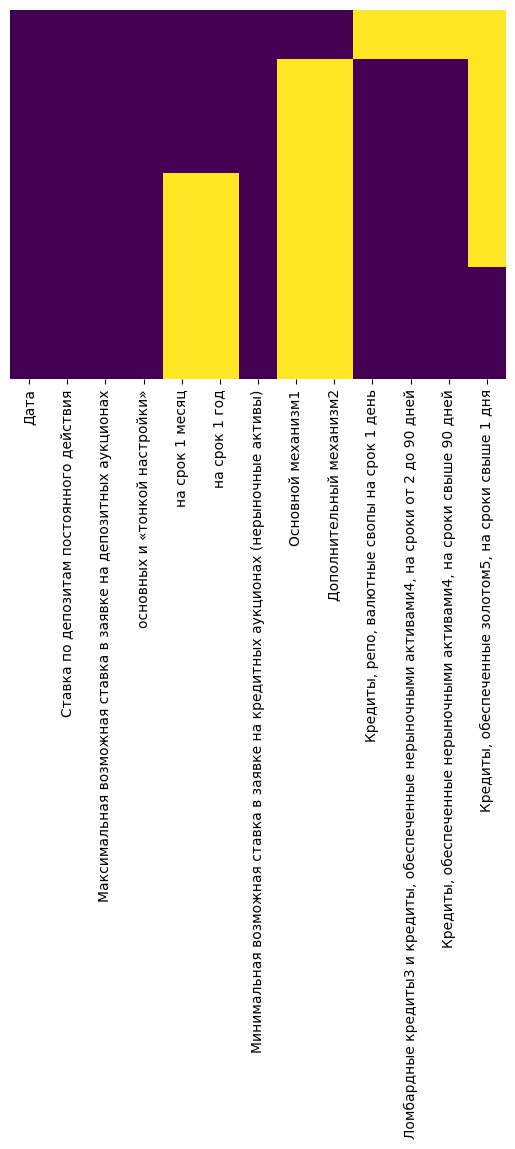

In [ ]:
sns.heatmap(df.isna(),yticklabels=False,cbar=False,cmap='viridis')

Фиолетовым цветом обозначаются данные, желтым – пропуски. В некоторых столбцах пропусков очень много – посчитаем их количество для того, чтобы определиться с дальнейшими действиями.

In [ ]:
df.isna().sum()

,0
Дата,0
Ставка по депозитам постоянного действия,0
Максимальная возможная ставка в заявке на депозитных аукционах,0
основных и «тонкой настройки»,0
на срок 1 месяц,1559
на срок 1 год,1559
Минимальная возможная ставка в заявке на кредитных аукционах (нерыночные активы),0
Основной механизм1,2426
Дополнительный механизм2,2426
"Кредиты, репо, валютные свопы на срок 1 день",371


Попробуем удалить столбцы, содержащие пропуски, и посмотрим коррелируют ли данные оставшихся столбцов между собой.

In [ ]:
df.dropna(how='any', axis=1, inplace=True)

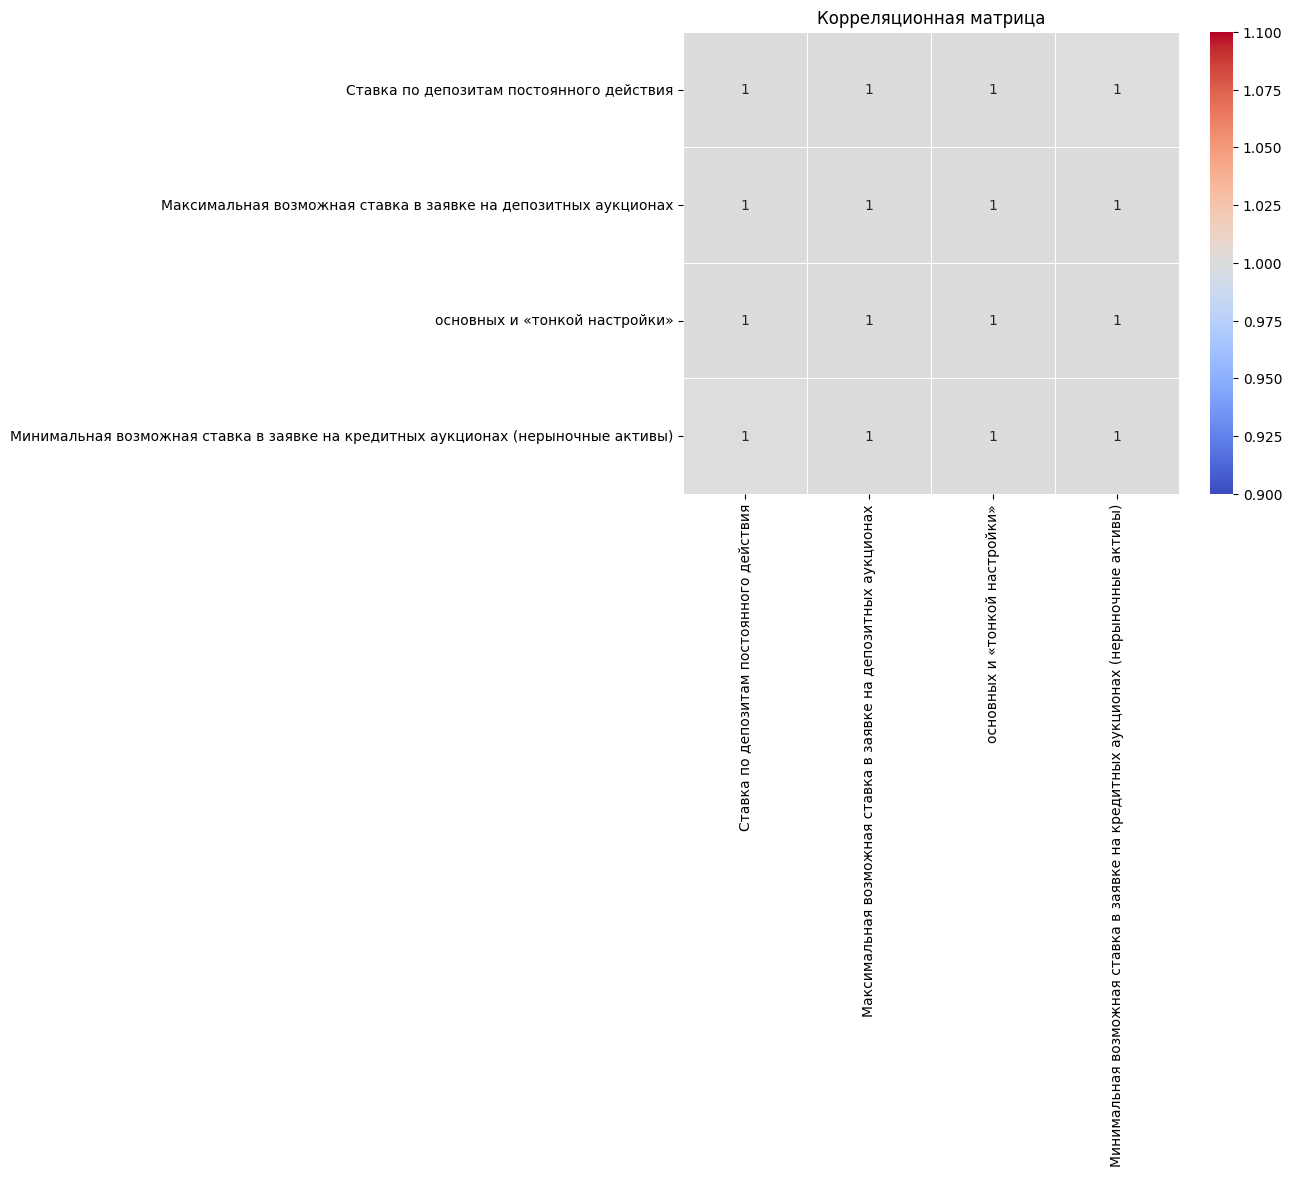

In [ ]:
correlation_matrix = df.iloc[:, 1:].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

Построение корреляционной матрицы показало, что между всеми оставшимися столбцами корреляция равна 1. Это значит, что для работы нам необходимо оставить только один столбец.

In [ ]:
df.drop(df.iloc[:, 2:], axis=1, inplace=True)

Переименуем столбцы для удобства дальнейшей работы.

In [ ]:
df.rename(columns={'Дата': 'date', 'Ставка по депозитам постоянного действия': 'permanent_deposit_rate'}, inplace=True)

Поработаем со столбцом даты: приведем его к типу «datetime» и сделаем индексом датафрейма.

In [ ]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [ ]:
df.set_index('date', inplace=True)

In [ ]:
df.sort_index(inplace=True)

Видим, что значения в столбце «permanent_deposit_rate» слишком велики, чтобы быть правильными процентными ставками.

In [ ]:
df['permanent_deposit_rate'].value_counts()

,count
permanent_deposit_rate,
650,433
1000,223
325,166
675,157
1500,154
625,150
900,126
700,110
2000,107


Проведем преобразование, чтобы значения стали корректными.

In [ ]:
df['permanent_deposit_rate'] = df['permanent_deposit_rate'] / 100

In [ ]:
df.head()

,permanent_deposit_rate
date,
2014-02-03,4.5
2014-02-04,4.5
2014-02-05,4.5
2014-02-06,4.5
2014-02-07,4.5


Таким образом, мы получили датафрейм без пропусков, с отсортированным столбцом индексов в виде даты и процентными ставками.

## Анализ выбросов

Посмотрим на распределение преобразованных данных на графике.

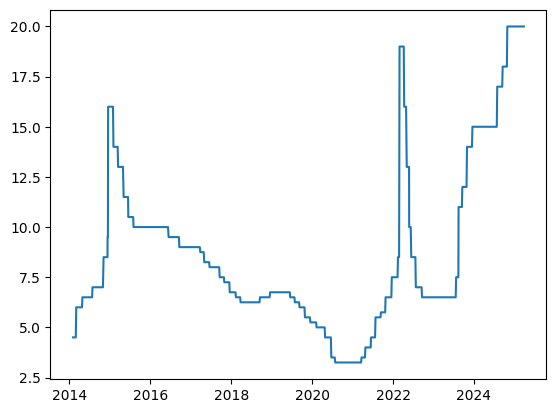

In [ ]:
plt.plot(df)

Видим, что ряд имеет несколько пиков, которые нельзя назвать периодичными. Значения изменяются примерно от 3 до 20.
Изобразим ящик с усами и выведем числовое описание датасета.


<Axes: >

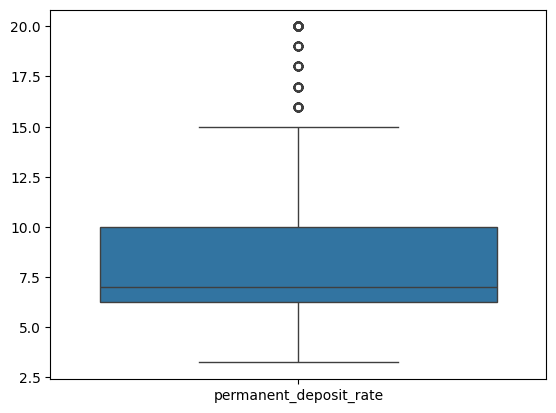

In [ ]:
sns.boxplot(df)

In [ ]:
df.describe()

,permanent_deposit_rate
count,2797.000000
mean,8.712192
std,4.199170
min,3.250000
25%,6.250000
50%,7.000000
75%,10.000000
max,20.000000


Первый квартиль (25% значений) находится в районе 6. Медина расположена чуть выше. Третий квартиль (75% значений) располагается на 10. Близкое расположение медианы и первого квартиля говорит о том, что распределение не симметрично, и большая часть значений находится ниже медианы. Выбросы отображаются в виде отдельных точек за пределами усов, в нашем случае являются аномально большими значениями по сравнению с остальными процентными ставками.

In [ ]:
max_rate = np.quantile(df, q=0.90)
max_rate

np.float64(15.0)

In [ ]:
min_rate = np.quantile(df, q=0.1)
min_rate

np.float64(4.5)

Попробуем сгладить ряд при помощи среднего.

In [ ]:
df['permanent_deposit_rate'].mean()

np.float64(8.712191633893458)

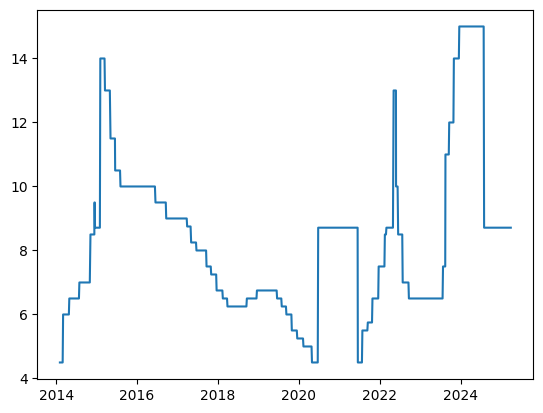

In [ ]:
df_mean = df.copy()
df_mean.loc[(df_mean["permanent_deposit_rate"] > max_rate) | (df_mean["permanent_deposit_rate"] < min_rate), 'permanent_deposit_rate'] = df['permanent_deposit_rate'].mean()
plt.plot(df_mean)

Посмотрим числовое описание датасета.

In [ ]:
df_mean.describe()

,permanent_deposit_rate
count,2797.000000
mean,8.331851
std,2.534474
min,4.500000
25%,6.500000
50%,8.250000
75%,9.000000
max,15.000000


Попробуем сгладить ряд при помощи медианы.

In [ ]:
df['permanent_deposit_rate'].median()

7.0

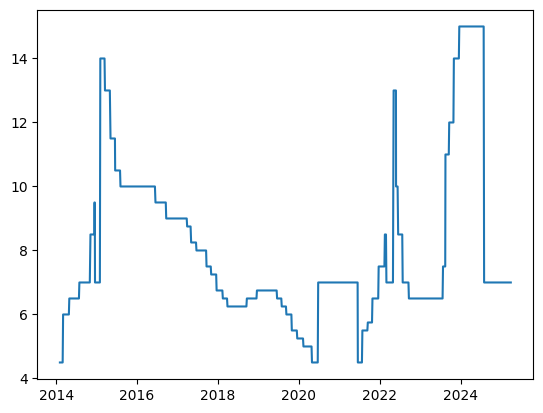

In [ ]:
df_median = df.copy()
df_median.loc[(df_median["permanent_deposit_rate"] > max_rate) | (df_median["permanent_deposit_rate"] < min_rate), 'permanent_deposit_rate'] = df['permanent_deposit_rate'].median()
plt.plot(df_median)

In [ ]:
df_median.describe()

,permanent_deposit_rate
count,2797.000000
mean,8.031284
std,2.572797
min,4.500000
25%,6.500000
50%,7.000000
75%,9.000000
max,15.000000


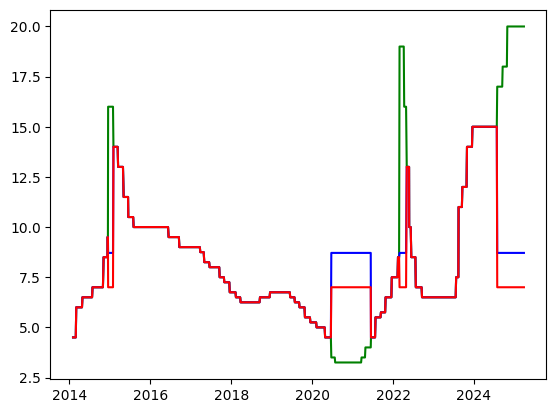

In [ ]:
plt.plot(df, label='rate', color='green')
plt.plot(df_mean, label='df_mean', color='blue')
plt.plot(df_median, label='df_median', color='red')

После сглаживания визуально заметно, что, несмотря на близость значений статистических характеристик к характеристикам исходного ряда (среднее арифметическое и медиана), визуально ряд, сглаженный с помощью медианы, более точно повторяет поведение исходного ряда, а ряд, сглаженный средним, имеет наиболее выраженные тенденции, характеризующие ряд.

## Выделение признаков

Выделим признаки из даты и попробуем выявить особенности процентной ставки по этим признакам. Построим boxplot по кварталам.

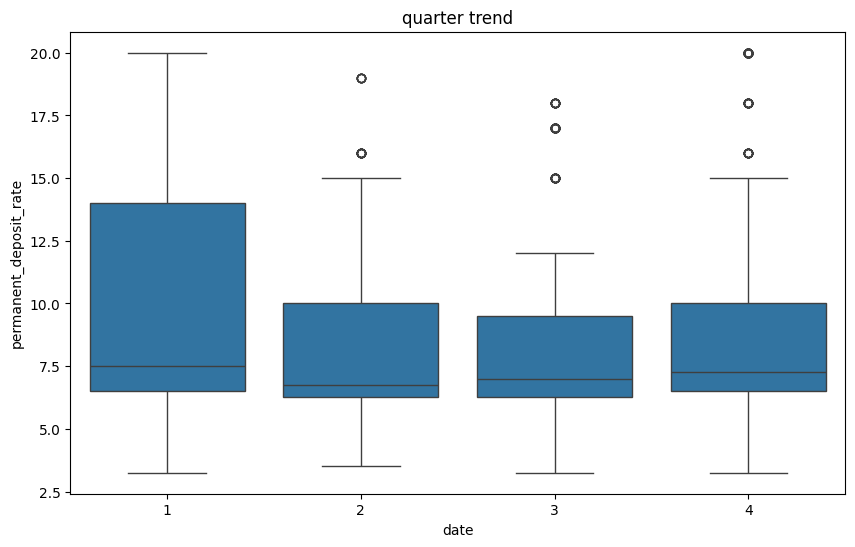

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df.index.quarter, y=df['permanent_deposit_rate'])
plt.title('quarter trend')
plt.show()

Медианные значения процентной ставки между кварталами почти не отличаются. Однако, видим, что наибольшие значения приходятся на первый квартал. Большие значения ставок для первого квартала могут стать выбросами в трех других кварталах.

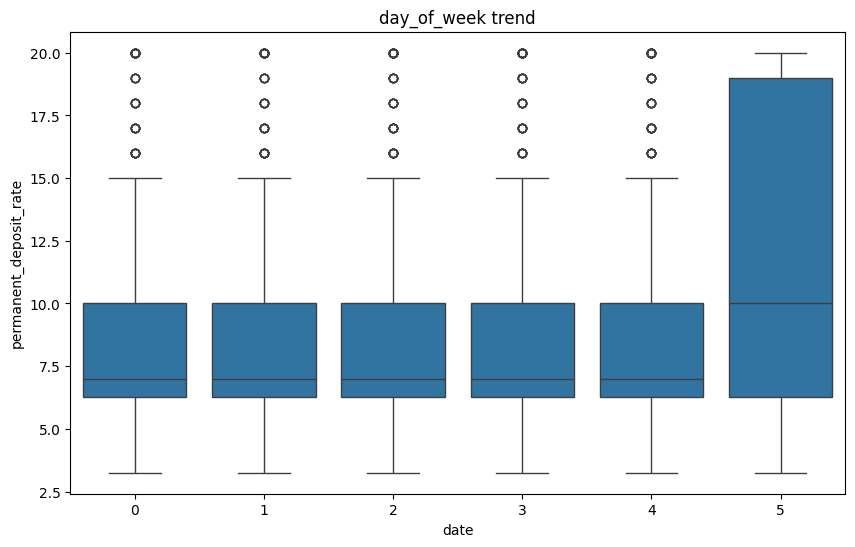

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df.index.day_of_week, y=df['permanent_deposit_rate'])
plt.title('day_of_week trend')
plt.show()

Наибольшие процентные ставки отмечаются в пятый день недели – пятница в наших данных. Большие значения ставок в пятницу могут считаться выбросами в другие дни недели. Также отметим, что во временных рядах отсутствуют субботы и воскресения, что связано с особенностями устанавливания ключевой ставки.

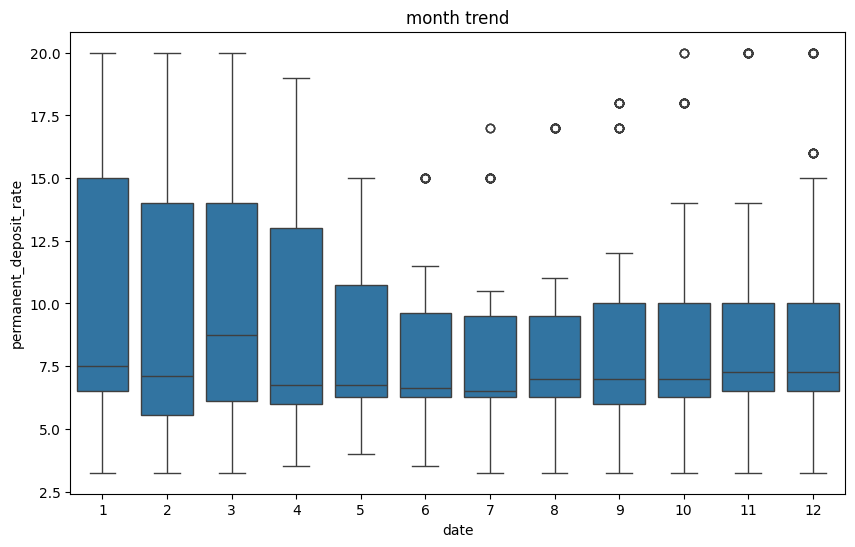

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df.index.month, y=df['permanent_deposit_rate'])
plt.title('month trend')
plt.show()

Наибольшие ставки отмечаются в зимние и весенние месяцы, далее существует тенденция к снижению процентной ставки в течение года.

In [ ]:
season = []
for date in df.index:
  if date.month in range(1, 3) or date.month == 12:
    season.append(1)
  elif date.month in range(3, 6):
    season.append(2)
  elif date.month in range(6, 9):
    season.append(3)
  else:
    season.append(4)

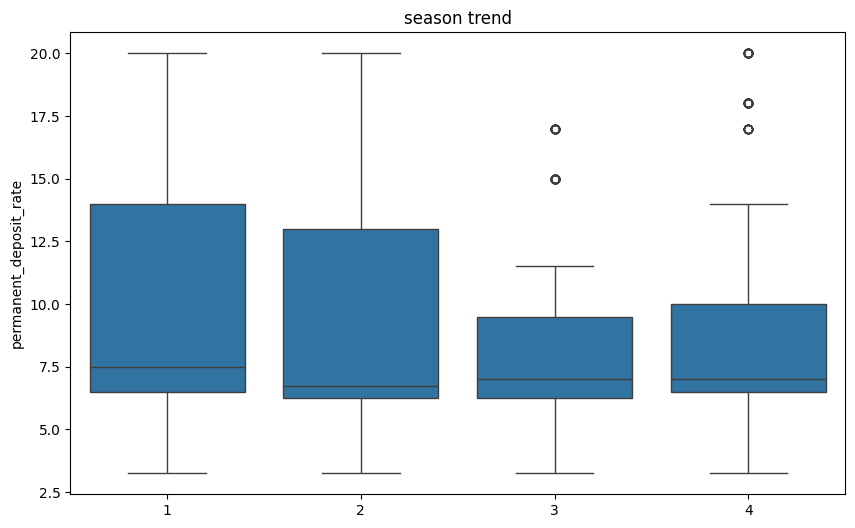

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=season, y=df['permanent_deposit_rate'])
plt.title('season trend')
plt.show()

На диаграммах размаха по сезонам это также подтверждается.

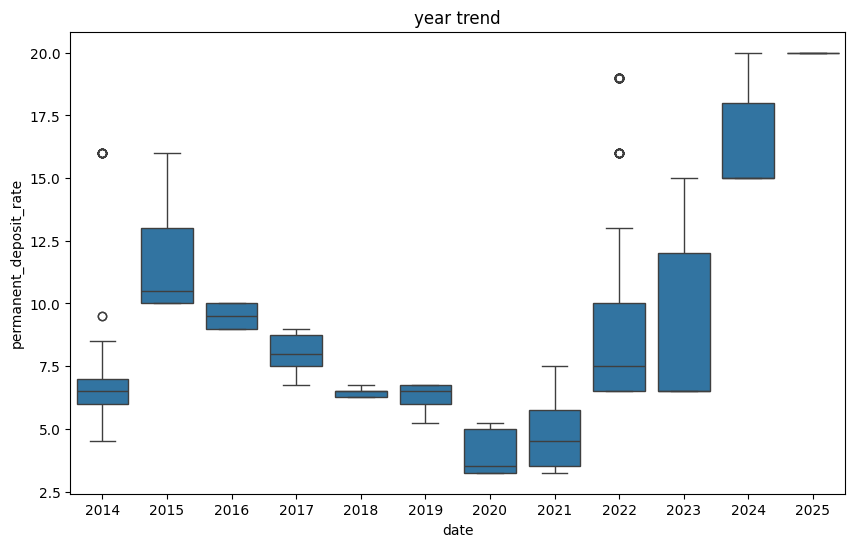

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df.index.year, y=df['permanent_deposit_rate'])
plt.title('year trend')
plt.show()

На диаграммах по годам видим, что медианные значения растут после 2020 года. Наибольший размах ставок отмечается в 2023 году. В 2022 году по сравнению с другими годами наблюдаются выбросы. Можем попробовать сопоставить значения процентных ставок с периодом пандемии, который пришелся на этот год. Возьмем данные из производственного календаря по дням, которые были объявлены нерабочими – создадим их них список.

In [ ]:
non_working_day = []
_2020 = (pd.date_range('2020-03-30', '2020-04-03').strftime('%Y-%m-%d').tolist() +
        pd.date_range('2020-04-06', '2020-04-10').strftime('%Y-%m-%d').tolist() +
        pd.date_range('2020-04-13', '2020-04-17').strftime('%Y-%m-%d').tolist() +
        pd.date_range('2020-04-20', '2020-04-24').strftime('%Y-%m-%d').tolist() +
        pd.date_range('2020-04-27', '2020-04-30').strftime('%Y-%m-%d').tolist() +
        pd.date_range('2020-05-06', '2020-05-08').strftime('%Y-%m-%d').tolist())
_2021 = (pd.date_range('2021-05-04', '2021-05-07').strftime('%Y-%m-%d').tolist() +
         pd.date_range('2021-11-01', '2021-11-03').strftime('%Y-%m-%d').tolist())

non_working_day = pd.to_datetime(_2020 + _2021)

Нерабочий день отметим 1.

In [ ]:
for i in df.index:
  if i in non_working_day:
    df.loc[i, 'non_working_day'] = 1
  else:
    df.loc[i, 'non_working_day'] = 0

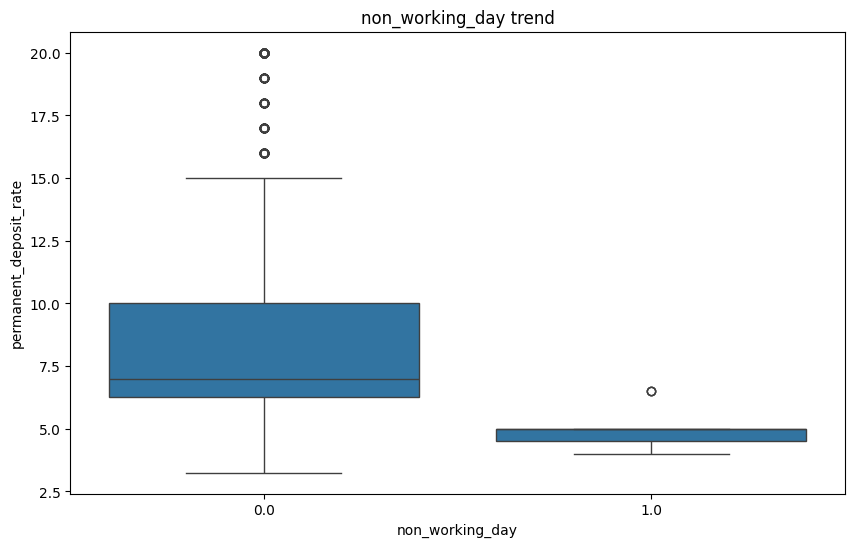

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['non_working_day'], y=df['permanent_deposit_rate'])
plt.title('non_working_day trend')
plt.show()

Видим, что нерабочие дни, связанные с распространением коронавируса (COVID-19), характеризуются большим числом выбросов. Получается, что данные значения являются аномалиями анализируемого временного ряда. Аномалии могут указывать на новые, редкие или неожиданные события, чем являлась пандемия и объявленные нерабочими дни.

In [ ]:
_2014 = ['2014-03-07', '2014-05-08', '2014-06-11', '2014-12-31']
_2015 = ['2015-04-30', '2015-05-08', '2015-06-11', '2015-11-03', '2015-12-31']
_2016 = ['2016-02-20', '2016-11-03']
_2017 = ['2017-02-22', '2017-03-07', '2017-11-03']
_2018 = ['2018-02-22', '2018-03-07', '2018-04-28', '2018-05-08', '2018-06-09', '2018-12-29']
_2019 = ['2019-02-22', '2019-03-07', '2019-04-30', '2019-05-08', '2019-06-11', '2019-12-31']
_2020 = ['2020-06-11', '2020-11-03', '2020-12-31']
_2021 = ['2021-02-20', '2021-04-30', '2021-06-11']
_2022 = ['2022-02-22', '2022-03-05', '2022-11-03']
_2023 = ['2023-02-22', '2023-03-07', '2023-11-03']
_2024 = ['2024-02-22', '2024-03-07', '2024-05-08', '2024-06-11', '2024-11-02']
_2025 = ['2025-03-07']

Обозначим во временном ряду сокращенный рабочий день 1.

In [ ]:
shortened_day = []
for i in ['_' + str(i) for i in range(2014, 2026)]:
  shortened_day.extend(eval(i))

shortened_day = pd.to_datetime(shortened_day)

In [ ]:
for i in df.index:
  if i in shortened_day:
    df.loc[i, 'shortened_day'] = 1
  else:
    df.loc[i, 'shortened_day'] = 0

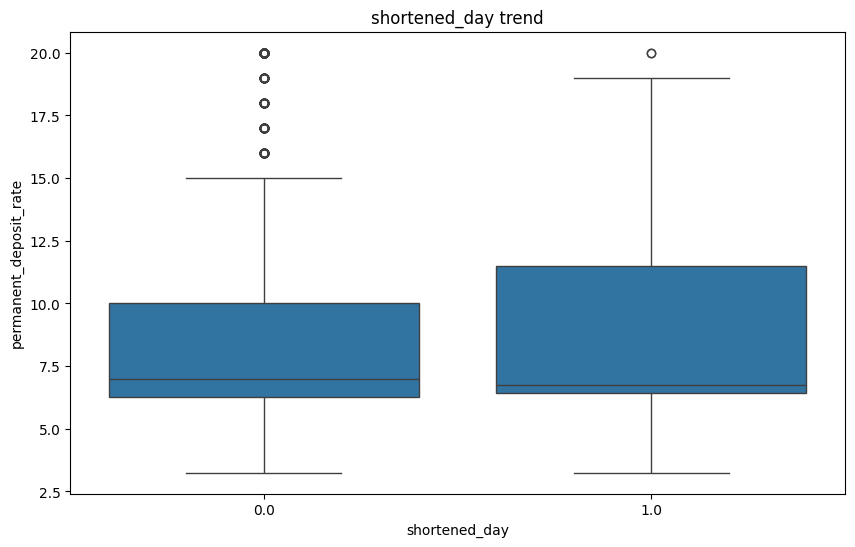

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['shortened_day'], y=df['permanent_deposit_rate'])
plt.title('shortened_day trend')
plt.show()

Сокращенные и несокращенные дни имеют как низкие, так и высокие значения процентных ставок.

## Выделение компонентов временного ряда

Попробуем выделить компоненты  временного ряда: тренд, сезонность и остатки. Попробуем рассмотреть различные методы декомпозиции временных рядов, так как правильное разделение компонент, мы можем получить представление о поведении данных и делать более точные прогнозы.

Попробуем применить аддитивное разложение – метод хорошо работает, когда величина сезонности не меняется в зависимости от величины временного ряда. При аддитивном разложении временной ряд выражается как сумма его компонентов:
$(t)=Trend_{t}+Seasonal_{t}+Residual_{t}$

Для этого воспользуемся функцией «seasonal_decompose» из библиотеки «statsmodels». Такое разложение помогает понять базовые закономерности в данных и используется для прогнозирования и обнаружения аномалий. Попробуем использовать для построения разные параметры – возьмем периоды от 1(годовой), 4 (квартальный), 12 (месячный); будем использовать two_sided=False для вычисления скользящего среднего только из прошлых значений.


### Classical Decomposition


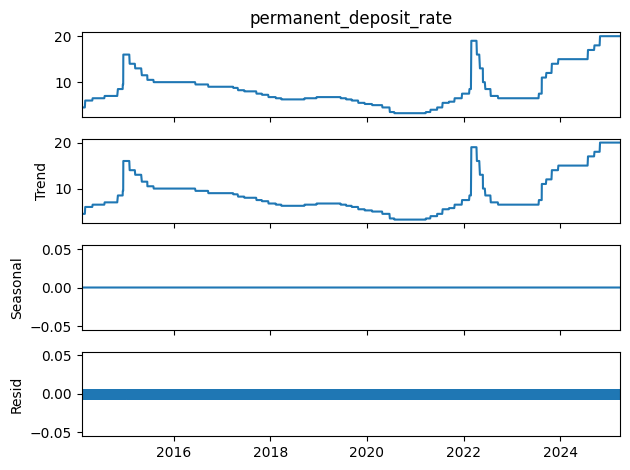

In [ ]:
result = sm.tsa.seasonal_decompose(df['permanent_deposit_rate'], model='additive', two_sided=False, period=1)
resplot = result.plot()
plt.show()

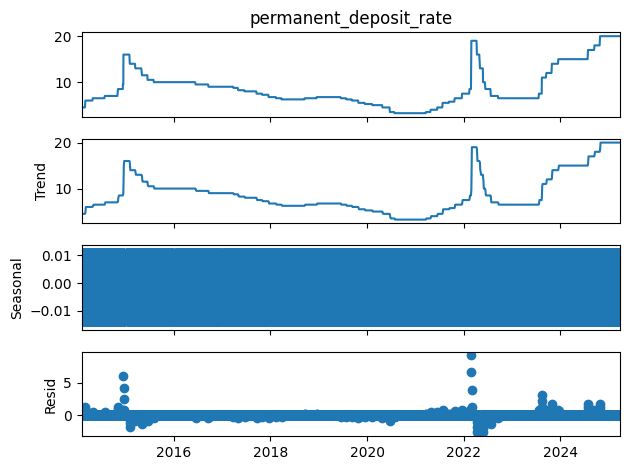

In [ ]:
result = sm.tsa.seasonal_decompose(df['permanent_deposit_rate'], model='additive', two_sided=False, period=4)
resplot = result.plot()
plt.show()

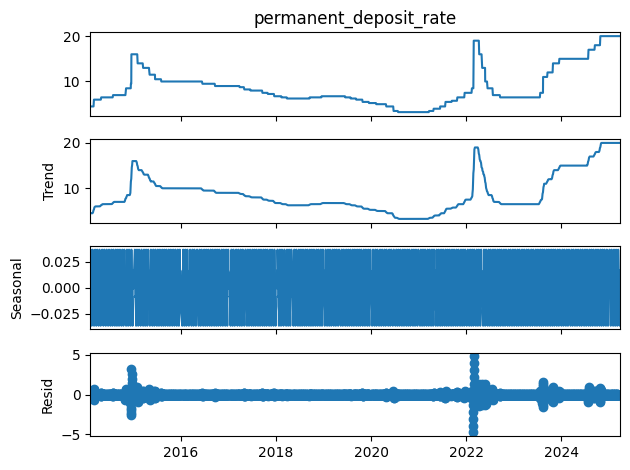

In [ ]:
result = sm.tsa.seasonal_decompose(df['permanent_deposit_rate'], two_sided=False, model='additive', period=12)
resplot = result.plot()
plt.show()

Видим, что временной ряд не имеет выраженной цикличности.

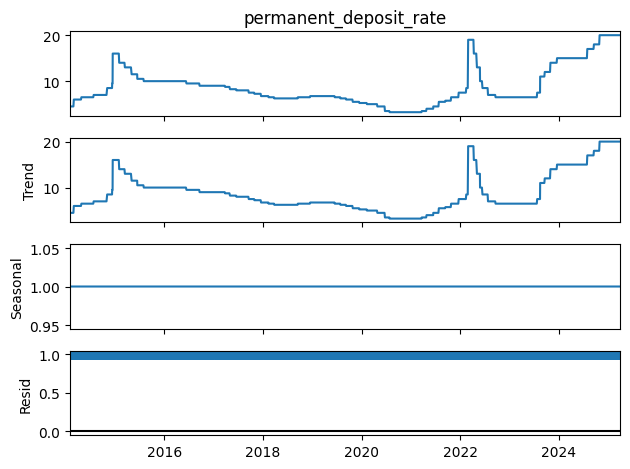

In [ ]:
result = sm.tsa.seasonal_decompose(df['permanent_deposit_rate'], model='multiplicative', two_sided=False, period=1)
resplot = result.plot()
plt.show()

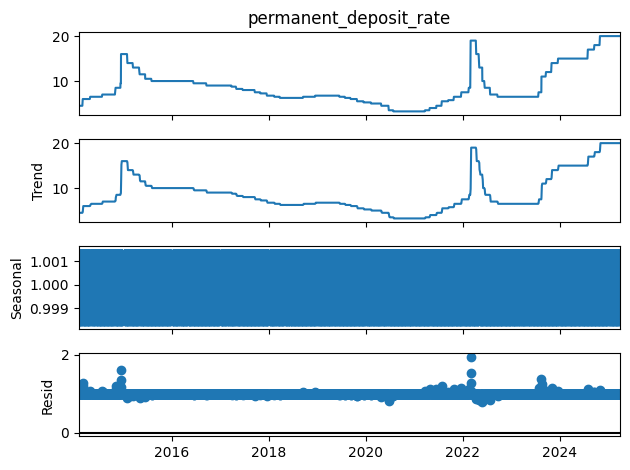

In [ ]:
result = sm.tsa.seasonal_decompose(df['permanent_deposit_rate'], model='multiplicative', two_sided=False, period=4)
resplot = result.plot()
plt.show()

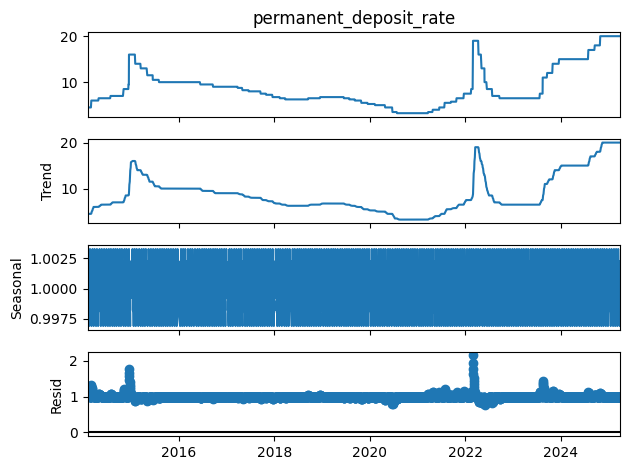

In [ ]:
result = sm.tsa.seasonal_decompose(df['permanent_deposit_rate'], model='multiplicative', two_sided=False, period=12)
resplot = result.plot()
plt.show()

Выделить цикличность по-прежнему не удается. Возможно, причина в том, что классические методы декомпозиции плохо подходят к исследуемому временному ряду. Classical Decomposition — один из ранних способов анализа временных рядов. Он предполагает, что сезонный компонент повторяется из года в год, а трендовый медленно меняется со временем. Для оценки тренда используются скользящие средние, а для вычисления сезонного компонента — остатки.



### STL Decomposition


Попробуем использовать STL Decomposition (сезонное и трендовое разложение с использованием Loess) - метод считается более гибкой и надежной. Локально-взвешенное сглаживание точечных диаграмм или метод Лоэсса — это непараметрический метод регрессии, используемый для сглаживания данных. В методе STL разложение выполняется путём итеративного применения сглаживания методом Лоэсса к временному ряду. Этот процесс помогает выявить как краткосрочные, так и долгосрочные изменения в данных, что делает его надёжным методом разложения временных рядов с нерегулярными или меняющимися закономерностями. Метод больше подходит для работы с нелинейными трендами и сложными сезонными паттернами. Метод более устойчив к выбросам.

Используем функцию STL из пакета statsmodels для разложения по методу STL. Параметр периода определяет периодичность сезонной составляющей. Будем использовать значение 13, что предполагает сезонный период в 13 временных точек. Это подходит для ежемесячных данных, где мы можем ожидать годовую сезонность (12 месяцев) плюс некоторую дополнительную гибкость. Используем взвешенную версию модели, устойчивую к некоторым видам выбросов.

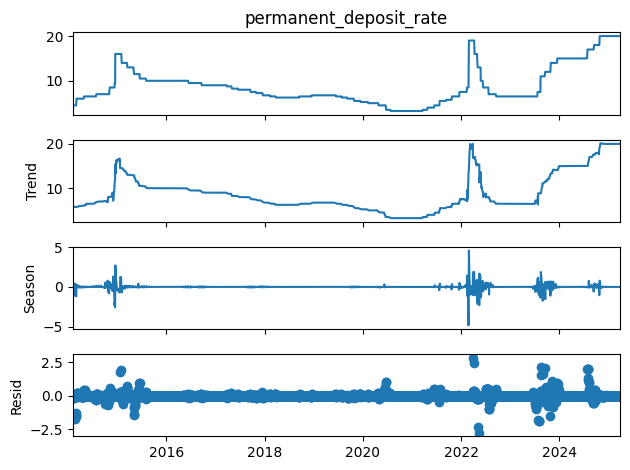

In [ ]:
stl = sm.tsa.STL(df['permanent_deposit_rate'], period=13, robust=True)
result = stl.fit()
result.plot()
plt.show()

Видим, что на графиках не удается выделить цикличность, остаточный компонент показывает, что в наборе данных есть шумы, но они не очень сильные.


Дполонительно проведем проверку при помощи теста Квятковского-Филлипса-Шмидта-Шина на отсутствие систематического тренда. Трендоустойчивость означает, что среднее значение и дисперсия временного ряда не меняются со временем, что подразумевает отсутствие систематического тренда.

Нулевая гипотеза (H0): ряд является стационарным, то есть не имеет единичного корня (единичный корень подразумевает стохастический тренд или нестационарность).

Альтернативная гипотеза (H1): ряд не является стационарным из-за единичного корня.

In [ ]:
stat, p, lags, crit = kpss(df['permanent_deposit_rate'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Trend-based stationarity')
else:
	print('No trend stationarity')

stat=1.732, p=0.010
No trend stationarity


Видим, что значение p-value меньше 0.05, значит временной ряд не является стационарным по тренду.Попробуем использовать тест

### SMA (Simple Moving Average)

Попробуем определить общие тенденции временного ряда. Воспользуемся для этого скользящими средними. Скользящие средние – это общее название для семейства функций, значения которых в каждой точке определения равны некоторому среднему значению исходной функции за предыдущий период. Обычно используется с данными временных рядов для сглаживания краткосрочных колебаний и выделения основных тенденций или циклов.

Простая скользящая средняя (SMA - Simple Moving Average) рассчитывается как среднее арифметическое данных за определённый короткий период, каждая цена имеет одинаковый вес. SMA хорошо подходит для сглаживания данных, при этом медленнее реагирует на изменения. Изобразим графически SMA за 3, 6 и 12 месяцев.

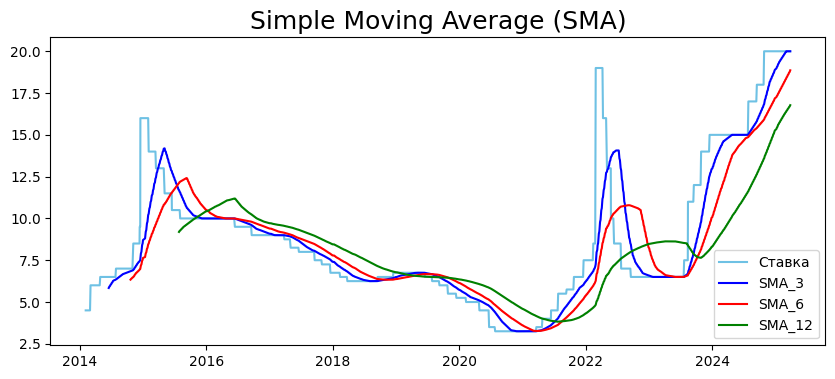

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['permanent_deposit_rate'], label='Ставка', color='#6EC1E4')
plt.plot(df["permanent_deposit_rate"].rolling(window=90).mean(), label='SMA_3', color='blue')
plt.plot(df['permanent_deposit_rate'].rolling(window=180).mean(), label='SMA_6', color='red')
plt.plot(df['permanent_deposit_rate'].rolling(window=365).mean(), label='SMA_12', color='green')
plt.title('Simple Moving Average (SMA)',fontsize=18)
plt.legend()
plt.show()

Каждый из графиков хорошо отражает тенденции временного ряда. Видим, что годовая скользящая средняя показывает самые сглаженные результаты.

### EMA (Exponential Moving Average)

Также отобразим более выраженные тенденции на графике при помощи EMA (Exponential Moving Average) – экспоненциальной скользящей средней - более точно следует за первоначальным значением, быстрее улавливая тренд. EMA придаёт больший вес и значимость самым последним точкам данных. Изобразим на графике EMA со сдвигами на 3, 6 и 12 месяцев для того, чтобы уловить тренды этих периодов.

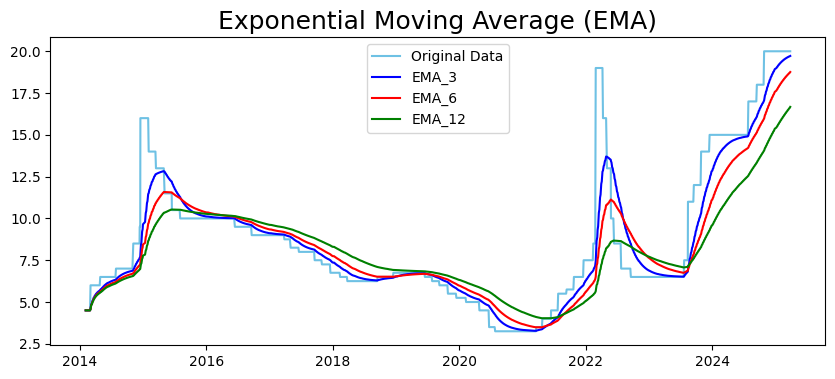

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['permanent_deposit_rate'], label='Original Data', color='#6EC1E4')
plt.plot(df["permanent_deposit_rate"].ewm(span=90).mean(), label='EMA_3', color='blue')
plt.plot(df['permanent_deposit_rate'].ewm(span=180).mean(), label='EMA_6', color='red')
plt.plot(df['permanent_deposit_rate'].ewm(span=365).mean(), label='EMA_12', color='green')
plt.title('Exponential Moving Average (EMA)',fontsize=18)
plt.legend()
plt.show()

Видим, что значения больших периодов более сглажены по сравнению с 90 днями, и наоборот.

### CMA (Cumulative Moving Average)

Для выделения общей тенденции временного ряда используем CMA (Cumulative Moving Average) – кумулятивную скользящую среднюю - это статистический инструмент, который позволяет предоставлять сглаженное представление о тенденциях и закономерностях в наборе данных. CMA ценится за способность сглаживать колебания в данных, обеспечивая более чёткое представление о долгосрочных тенденциях без чрезмерной чувствительности к краткосрочным аномалиям. Он рассчитывается путём суммирования всех наблюдений до определённой точки и деления суммы на количество наблюдений. При расчёте CMA нет фиксированного размера окна, он продолжает увеличиваться с течением времени. CMA показывает среднюю динамику данных, т. е. динамику процентной ставки с течением времени.

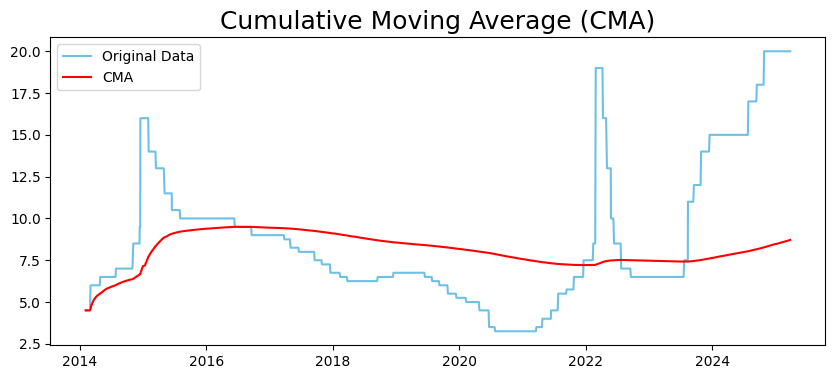

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df['permanent_deposit_rate'], label='Original Data', color='#6EC1E4')
plt.plot(df['permanent_deposit_rate'].expanding().mean(), label='CMA', color='red')
plt.title('Cumulative Moving Average (CMA)',fontsize=18)
plt.legend()
plt.show()

Видим, что сглаженное представление вначале демонстрировало тенденцию к росту, затем снижение, и в правой части вновь наметилась тенденция к увеличению ставки.

### Стационарность.
Временной ряд считается стационарным, если его статистические свойства (такие как среднее значение, дисперсия и автокорреляция) остаются неизменными с течением времени. Нестационарные временные ряды, напротив, демонстрируют тенденции, сезонность или изменяющиеся статистические свойства. Многие методы прогнозирования временных рядов предполагают стационарность, и данные часто приходится преобразовывать, чтобы сделать их стационарными (например, с помощью дифференцирования).

Графический анализ заставляет нас предполагать, что исследуемый временной ряд не является стационарным. Разброс значений на графике не является стационарным, так как визуально не имеет предсказуемых закономерностей.

Проведем тест Дики-Фуллера на стационарность.

H0 - ряд нестационарен

H1 - ряд стационарен

In [ ]:
result = adfuller(df['permanent_deposit_rate'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.972320
p-value: 0.763225
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


Значение p-value больше 0.05, значит мы не можем отклонить нулевую гипотезу о нестационарности ряда, ряд нестационарен.

In [ ]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')


check_stationarity(df['permanent_deposit_rate'])

ADF Statistic: -0.9723204922584766
p-value: 0.7632254422305945
Non-Stationary


Чтобы свести ряд к стационарности, можем выполнить дифференцирование. Попробуем выполнить дифференцирование 1, 30, 90, 365 порядков, и снова провести тест Дики-Фуллера для проверки стационарности. Если значение p в результате теста будет меньше 0,05, данные можно считать стационарными и готовыми к моделированию ARIMA.

In [ ]:
data_diff = df['permanent_deposit_rate'].diff().dropna()
result_diff = adfuller(data_diff)
print('ADF Statistic: %f' % result_diff[0], 'p-value: %f' % result_diff[1])

ADF Statistic: -10.057797 p-value: 0.000000


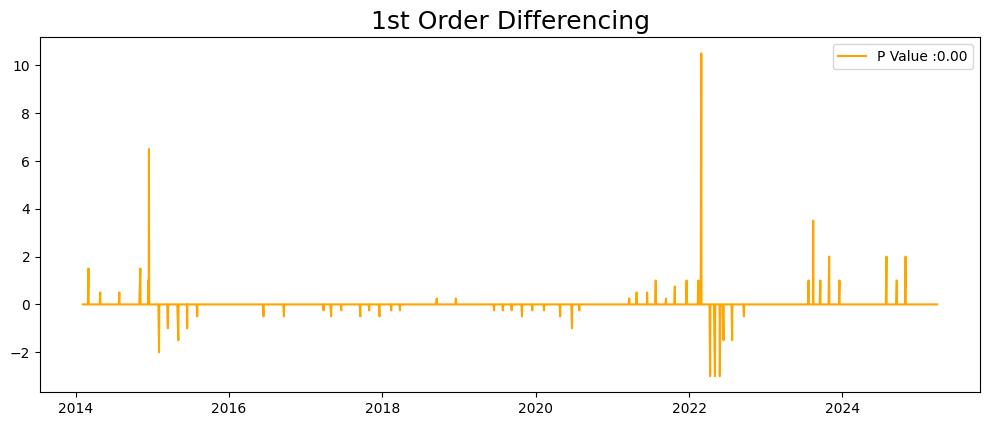

In [ ]:
plt.figure(figsize=(10, 12))

plt.subplot(311)
p_value = adfuller(data_diff)[1]
plt.plot(data_diff, label=f'P Value :{p_value:0.2f}',color='orange')
plt.title('1st Order Differencing',fontsize='18')
plt.legend()

plt.tight_layout()
plt.show()

ADF Statistic: -9.299117 p-value: 0.000000


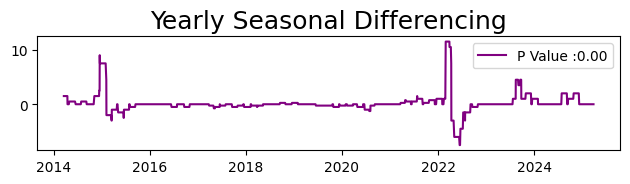

In [ ]:
seasonal_diff_30 = df['permanent_deposit_rate'].diff(30).dropna()
result_diff_30 = adfuller(seasonal_diff_30)
print('ADF Statistic: %f' % result_diff_30[0], 'p-value: %f' % result_diff_30[1])

plt.subplot(313)
p_value = adfuller(seasonal_diff_30)[1]
plt.plot(seasonal_diff_30, label=f'P Value :{p_value:0.2f}',color='purple')
plt.title('Yearly Seasonal Differencing',fontsize='18')
plt.legend()


plt.tight_layout()
plt.show()

ADF Statistic: -4.547912 p-value: 0.000161


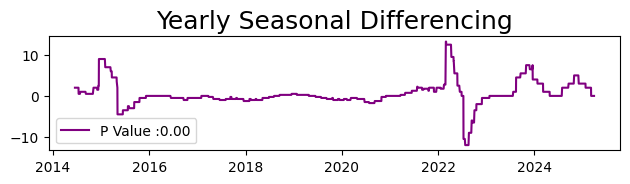

In [ ]:
seasonal_diff_90 = df['permanent_deposit_rate'].diff(90).dropna()
result_diff_90 = adfuller(seasonal_diff_90)
print('ADF Statistic: %f' % result_diff_90[0], 'p-value: %f' % result_diff_90[1])

plt.subplot(313)
p_value = adfuller(seasonal_diff_90)[1]
plt.plot(seasonal_diff_90, label=f'P Value :{p_value:0.2f}',color='purple')
plt.title('Yearly Seasonal Differencing',fontsize='18')
plt.legend()


plt.tight_layout()
plt.show()

ADF Statistic: -2.222508 p-value: 0.198178


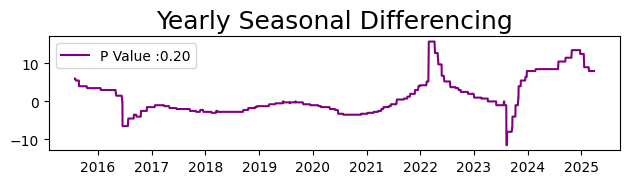

In [ ]:
seasonal_diff_365 = df['permanent_deposit_rate'].diff(365).dropna()
result_diff_365 = adfuller(seasonal_diff_365)
print('ADF Statistic: %f' % result_diff_365[0], 'p-value: %f' % result_diff_365[1])

plt.subplot(313)
p_value = adfuller(seasonal_diff_365)[1]
plt.plot(seasonal_diff_365, label=f'P Value :{p_value:0.2f}',color='purple')
plt.title('Yearly Seasonal Differencing',fontsize='18')
plt.legend()


plt.tight_layout()
plt.show()

Как видно, данные начиная с первого порядка становятся стационарными, однако данные с периодом 365 остаются нестационарными.

Построим графики ACF и PACF, которые помогут выявить временные зависимости в наборе данных.

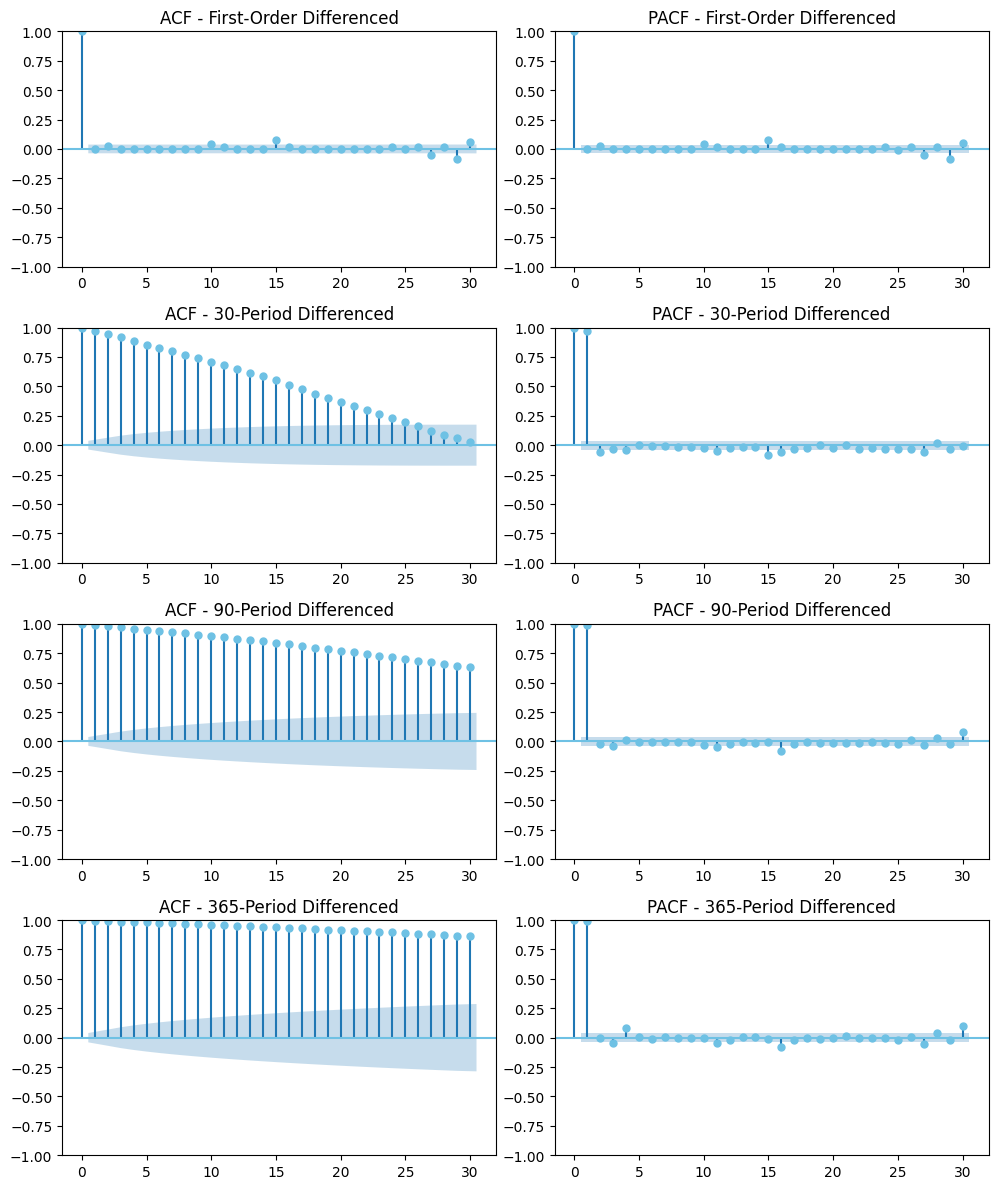

In [ ]:
# Set up a figure with multiple subplots for each differenced data series
plt.figure(figsize=(10, 12))

# First-order differenced data (diff_data_1)
plt.subplot(4, 2, 1)
plot_acf(data_diff, lags=30, color='#6EC1E4', ax=plt.gca())
plt.title('ACF - First-Order Differenced')

plt.subplot(4, 2, 2)
plot_pacf(data_diff, lags=30, color='#6EC1E4', ax=plt.gca())
plt.title('PACF - First-Order Differenced')

# 5-period differenced data (diff_data_5)
plt.subplot(4, 2, 3)
plot_acf(seasonal_diff_30, lags=30, color='#6EC1E4', ax=plt.gca())
plt.title('ACF - 30-Period Differenced')

plt.subplot(4, 2, 4)
plot_pacf(seasonal_diff_30, lags=30, color='#6EC1E4', ax=plt.gca())
plt.title('PACF - 30-Period Differenced')

# 20-period differenced data (diff_data_20)
plt.subplot(4, 2, 5)
plot_acf(seasonal_diff_90, lags=30, color='#6EC1E4', ax=plt.gca())
plt.title('ACF - 90-Period Differenced')

plt.subplot(4, 2, 6)
plot_pacf(seasonal_diff_90, lags=30, color='#6EC1E4', ax=plt.gca())
plt.title('PACF - 90-Period Differenced')

# 252-period differenced data (diff_data_252)
plt.subplot(4, 2, 7)
plot_acf(seasonal_diff_365, lags=30, color='#6EC1E4', ax=plt.gca())
plt.title('ACF - 365-Period Differenced')

plt.subplot(4, 2, 8)
plot_pacf(seasonal_diff_365, lags=30, color='#6EC1E4', ax=plt.gca())
plt.title('PACF - 365-Period Differenced')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

На обоих графиках по горизонтальной оси отложены ставки, по вертикальной — коэффициенты корреляции в диапазоне от -1 до 1, где -1 означает идеальную отрицательную корреляцию, 0 — отсутствие корреляции, а 1 — идеальную положительную корреляцию. Синяя заштрихованная область представляет собой доверительный интервал для коэффициентов корреляции. Если коэффициент корреляции при определённом запаздывании находится за пределами доверительного интервала, это означает, что коэффициент корреляции статистически значим и не является случайным.
Данные, дифференцированные по первому порядку, не показывают значительных всплесков в ACF и PACF, что указывает на белый шум. График ACF, дифференцированный по 30 периодам, медленно затухает до 30-го лага, а график PACF показывает всплески на 1-м лаге, что может указывать на сезонность и авторегрессионный компонент. Аналогичные графики ACF и PACF, дифференцированные по 90 и 365 периодам, также показывают сезонность и авторегрессионный компонент AR.


# ARIMA

ARIMA (англ. autoregressive integrated moving average) — интегрированная модель авторегрессии - скользящего среднего, метод анализа временных рядов. ARIMA - одна из самых широко используемых моделей, которая может применяться практически к любой задаче прогнозирования временных рядов. ARIMA была выбрана, так как позволяет делать обоснованные предсказания на основе исторических данных. Модель ARIMA рассматривает прошлые наблюдения и базовый шум, что позволяет идентифицировать и моделировать автокорреляцию и компоненты скользящей средней.

Недостатком ARIMA является то, что модель не подходит для долгосрочного прогнозирования, однако в наши задачи долгосрочное прогнозирование не входит. Сложность в нашей работе может вызвать чувствительность к выбросам модели и плохое предсказание ей поворотных моментов - предположения модели достаточно линейны и не учитывают резких изменений.  

<Axes: xlabel='date'>

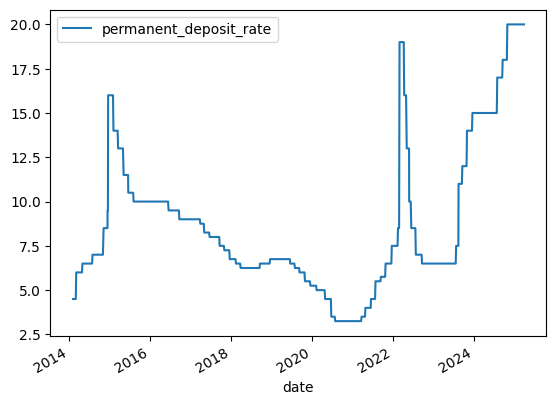

In [ ]:
df.plot()

<Axes: ylabel='permanent_deposit_rate'>

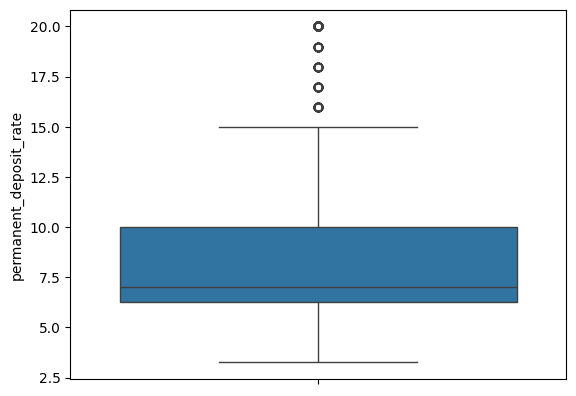

In [ ]:
sns.boxplot(df['permanent_deposit_rate'])

Анализируемый временной ряд содержит несколько пиковых значений, его дисперсия не остается постоянной на протяжении всего времени. Поэтому сначала преобразуем ряд, чтобы стабилизировать его дисперсию. Для этого можем взять логарифм

<Axes: xlabel='date'>

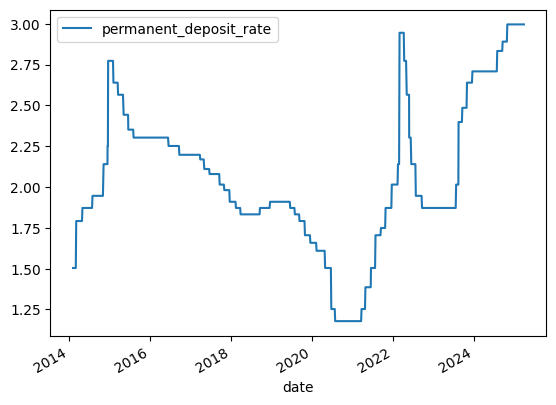

In [ ]:
(np.log(df)).plot()

Ряд стал менее изменчив по сравнению с оригинальным.

Разделим временной ряд на обучающую и тестовую выборки. Мы определяем последние 30% значений данных как тестовую выборку, а предыдущие данные — как обучающую выборку


In [ ]:
train = df.drop(df.tail((int(30 * len(df) / 100))).index)
test = df.tail((int(30 * len(df) / 100)))

In [ ]:
adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

p-value: 0.36381345501870155


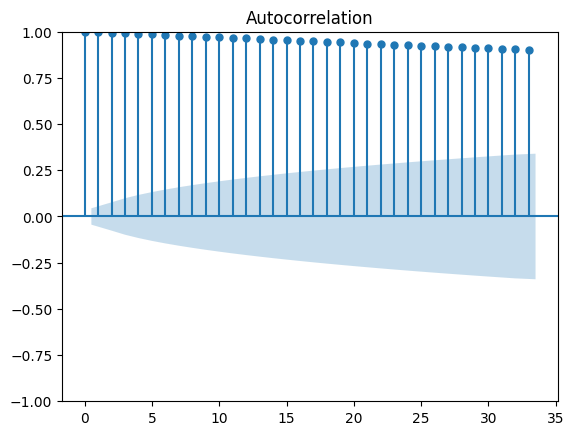

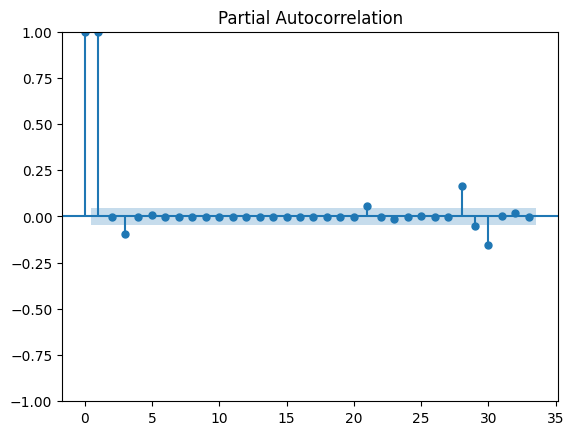

In [ ]:
acf_original = plot_acf(train)

pacf_original = plot_pacf(train)

График АКФ (слева) показывает, что корреляции с запаздыванием высокие и положительные с очень медленным затуханием. График ПАКФ (справа) показывает, что частичные автокорреляции имеют пик при запаздывании 1. Оба этих признака указывают на наличие тренда во временном ряду. Таким образом, наш временной ряд не является стационарным.

Можем использовать дифференцирование, чтобы сделать ряд стационарным.


<Axes: xlabel='date'>

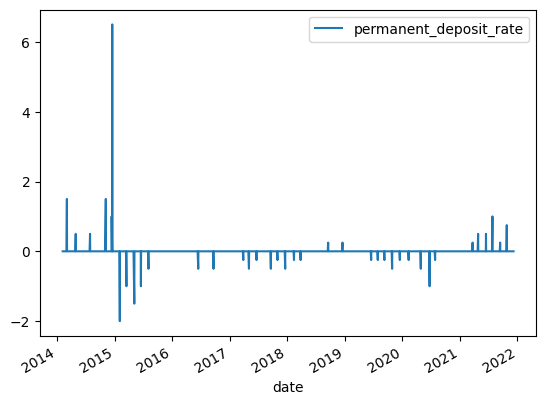

In [ ]:
train_diff = train.diff().dropna()
train_diff.plot()

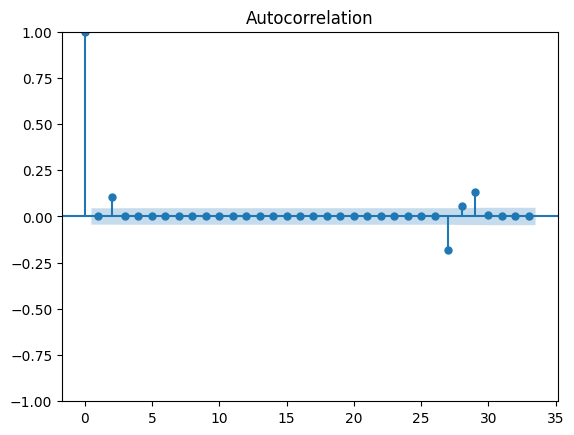

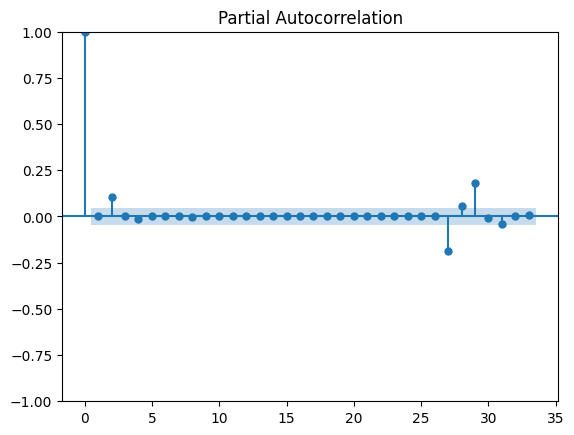

In [ ]:
acf_diff = plot_acf(train_diff)
pacf_diff = plot_pacf(train_diff)

По сравнению с исходным рядом график ACF (слева) более стабилен. График PACF (справа) также показывает менее сильный пик при задержке 1. Это признаки того, что ряд более стабилен.

Мы также можем количественно оценить результат, проведя тест ADF для этой серии.



In [ ]:
adf_test = adfuller(train_diff)
print(f'p-value: {adf_test[1]:.6f}')

p-value: 0.000000


Значение p указывает на то, что мы можем отвергнуть нулевую гипотезу при уровне значимости 5%. Таким образом, можно сделать вывод, что временной ряд с первой разностью, скорее всего, является стационарным. Так мы определили часть I в модели ARIMA(p, d, q). Нам нужно, чтобы параметр d был равен 1.

Далее попробуем определить параметры p и q для модели ARIMA. Для этого вновь обратимся к графикам ACF и PACF на основе временного ряда с первой разностью train_diff.

PACF измеряет балансовую дисперсию лагов; он помогает понять, следует ли включать лаги в авторегрессионные (AR) модели. В то время как ACF измеряет корреляции с лагами, он помогает оценить модели скользящего среднего (MA). В большинстве случаев следует сосредоточиться либо на AR-моделях, либо на MA-моделях, а не на их сочетании.

Для нашего дифференцированного ряда PACF имеет большой пик при лаговой задержке 2 и показывает значимые задержки при 27, 29. ACF демонстрирует аналогичную картину.

Таким образом, мы можем попробовать модели ARIMA с параметром p, равным 2. Поэтому мы будем использовать модель ARIMA(2, 1, 0). Также можно попробовать модель ARIMA(0, 1, 2).


In [ ]:
model_p = ARIMA(train_diff, order=(2,1,0))
model_p_fit = model_p.fit()
print(model_p_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     permanent_deposit_rate   No. Observations:                 1957
Model:                     ARIMA(2, 1, 0)   Log Likelihood                 354.633
Date:                    Mon, 07 Apr 2025   AIC                           -703.267
Time:                            12:59:44   BIC                           -686.531
Sample:                                 0   HQIC                          -697.115
                                   - 1957                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7110      0.003   -283.973      0.000      -0.716      -0.706
ar.L2         -0.2884      0.003   -110.589      0.000      -0.293      -0.283
sigma2         0.040

Прежде чем использовать эту модель для прогнозирования временных рядов, нужно убедиться, что модель собрала достаточно информации из данных. Проверим это, взглянув на остатки. Если модель хорошая, то остатки должны выглядеть как белый шум – случайно распределенными. Нанесем на график остатки и их плотность.

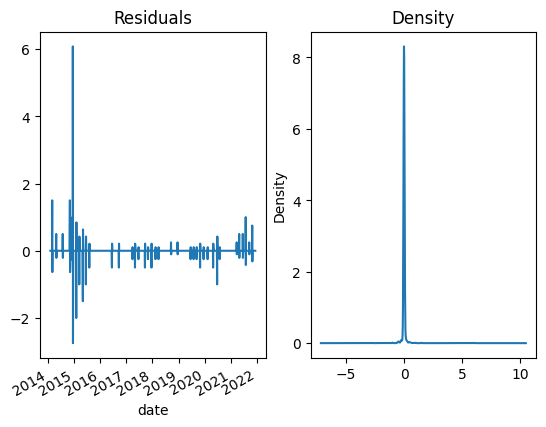

In [ ]:
residuals_p = model_p_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals_p.plot(title='Residuals', ax=ax[0])
residuals_p.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

Сложно сказать однозначно, являются ли остатки случайно распределенными. Плотность выглядит нормально распределённой со средним значением около 0, однако распределение слишком вытянутое. Мы также можем посмотреть графики ACF и PACF остатков.

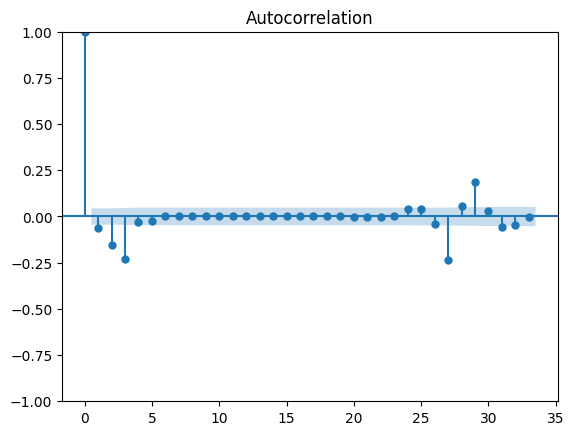

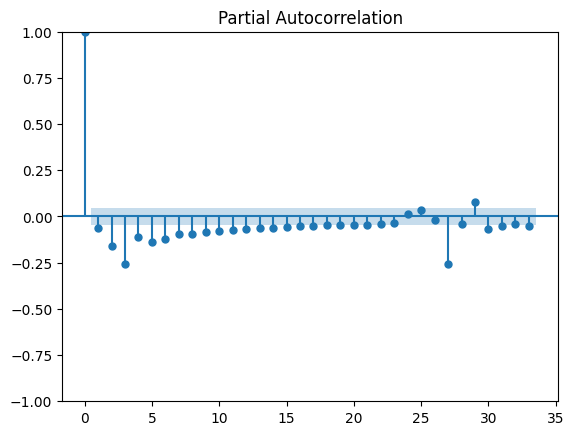

In [ ]:
acf_res = plot_acf(residuals_p)
pacf_res = plot_pacf(residuals_p)

На графиках присутствуют несколько "всплесков". Вероятно, остатки сложно назвать случайно распределенными. Попробуем сделать прогнозы при помощи модели, также построим график, включая тестовый набор данных.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='date'>

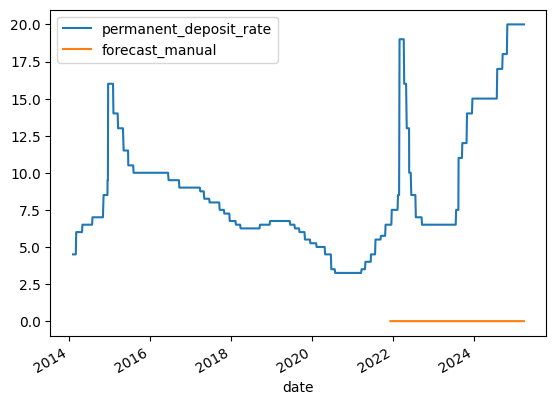

In [ ]:
forecast_test = model_p_fit.forecast(len(test))
df['forecast_manual'] = [None]*len(train) + list(forecast_test)
df.plot()

При помощи данной модели не получается получить адекватных предсказаний. Видим на графике, что значения далеки от реальных. Предсказанные значения лежат в районе 0 в виде одной линии, что говорит о некорректной работе модели. Вычислим значения метрик.

In [ ]:
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 12.214541120381407
mape - manual: 1.0
rmse - manual: 13.212551370072088


Попробуем построить еще один вариант модели.

In [ ]:
model_q = ARIMA(train_diff, order=(0,1,2))
model_q_fit = model_q.fit()
print(model_q_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:     permanent_deposit_rate   No. Observations:                 1957
Model:                     ARIMA(0, 1, 2)   Log Likelihood                 588.637
Date:                    Tue, 08 Apr 2025   AIC                          -1171.275
Time:                            18:16:14   BIC                          -1154.539
Sample:                                 0   HQIC                         -1165.123
                                   - 1957                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9983      0.084    -11.847      0.000      -1.163      -0.833
ma.L2          0.0007      0.083      0.009      0.993      -0.162       0.163
sigma2         0.032

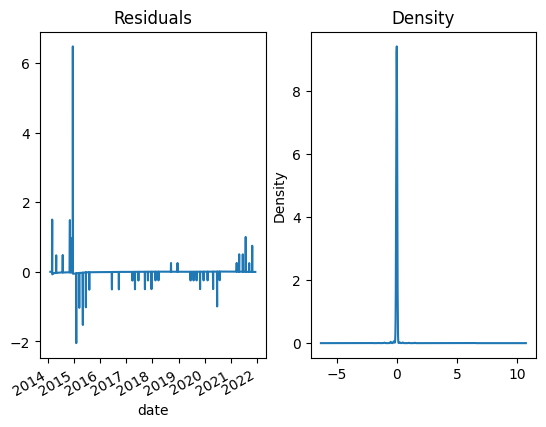

In [ ]:
residuals_q = model_q_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals_q.plot(title='Residuals', ax=ax[0])
residuals_q.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

Мы также можем посмотреть графики АКФ и ПАКФ остатков.

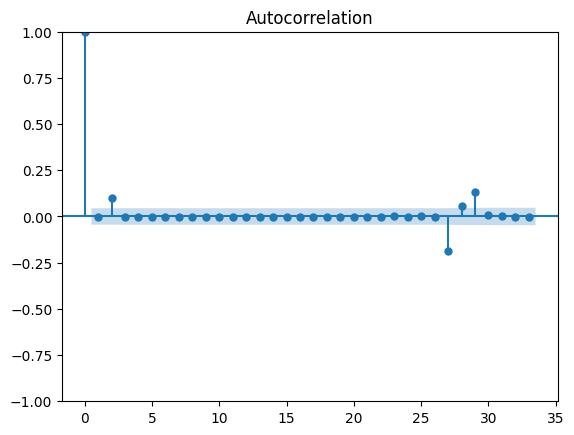

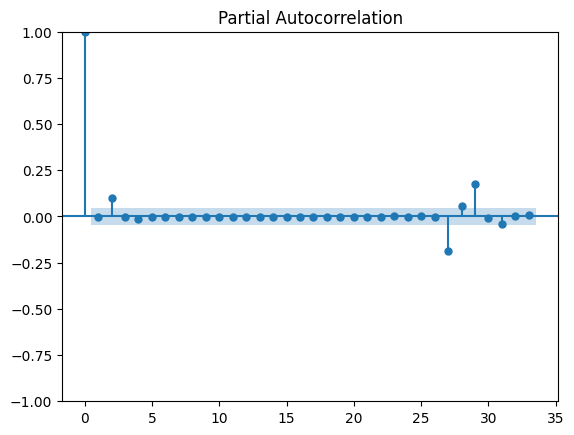

In [ ]:
acf_res = plot_acf(residuals_q)
pacf_res = plot_pacf(residuals_q)

Распределение остатков похоже на предыдущее, как и графики ACF и PACF. На графиках присутствуют несколько "всплесков". Вероятно, остатки сложно назвать случайно распределенными. Попробуем сделать прогнозы при помощи модели, также построим график, включая тестовый набор данных.

<Axes: xlabel='date'>

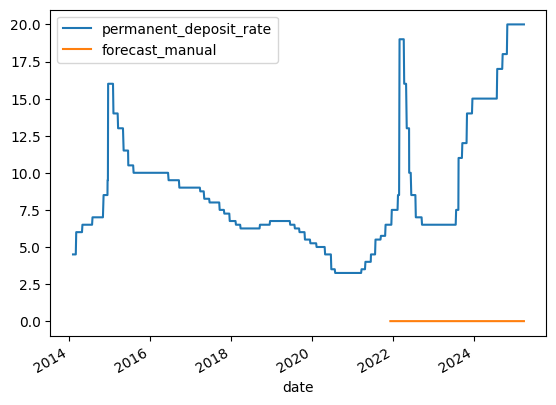

In [ ]:
forecast_test = model_q_fit.forecast(len(test))
df['forecast_manual'] = [None]*len(train) + list(forecast_test)
df.plot()

При помощи данной модели не получается получить адекватных предсказаний. Видим на графике, что значения далеки от реальных. Предсказанные значения лежат в районе 0 в виде одной линии, что говорит о некорректной работе модели. Вычислим значения метрик.

In [ ]:
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 12.211328552746815
mape - manual: 0.9996831688488278
rmse - manual: 13.209581521795922


Построим еще вариант модели.

In [ ]:
model_pq = ARIMA(train_diff, order=(2,1,2))
model_pq_fit = model_pq.fit()
print(model_pq_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     permanent_deposit_rate   No. Observations:                 1957
Model:                     ARIMA(2, 1, 2)   Log Likelihood                 599.258
Date:                    Mon, 07 Apr 2025   AIC                          -1188.516
Time:                            13:12:40   BIC                          -1160.623
Sample:                                 0   HQIC                         -1178.263
                                   - 1957                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0033      0.834      0.004      0.997      -1.631       1.638
ar.L2          0.1045      0.007     15.975      0.000       0.092       0.117
ma.L1         -1.002

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


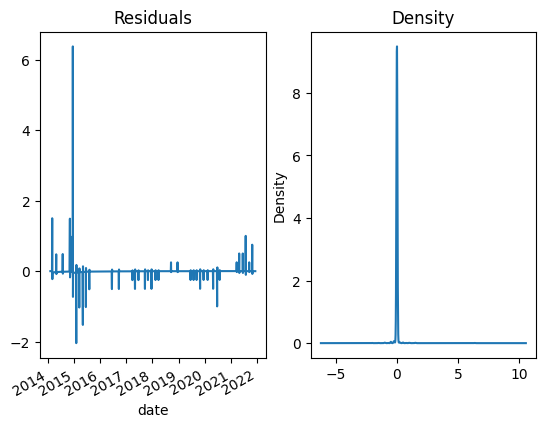

In [ ]:
residuals_pq = model_pq_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals_pq.plot(title='Residuals', ax=ax[0])
residuals_pq.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

Мы также можем посмотреть графики АКФ и ПАКФ остатков.

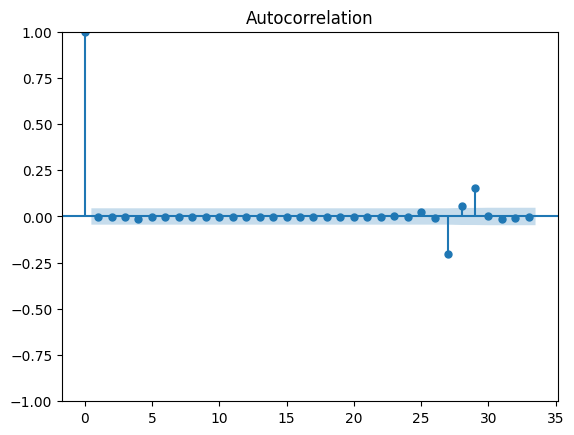

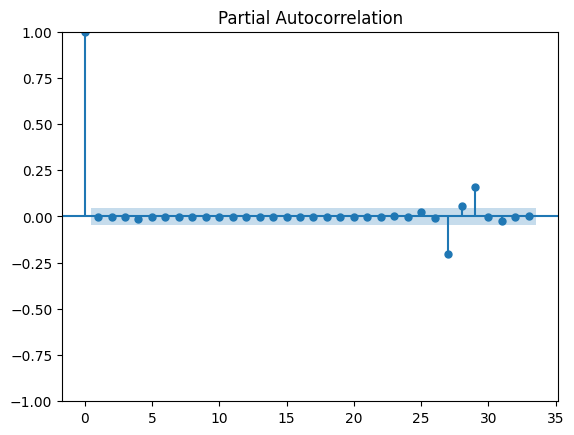

In [ ]:
acf_res = plot_acf(residuals_pq)
pacf_res = plot_pacf(residuals_pq)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: xlabel='date'>

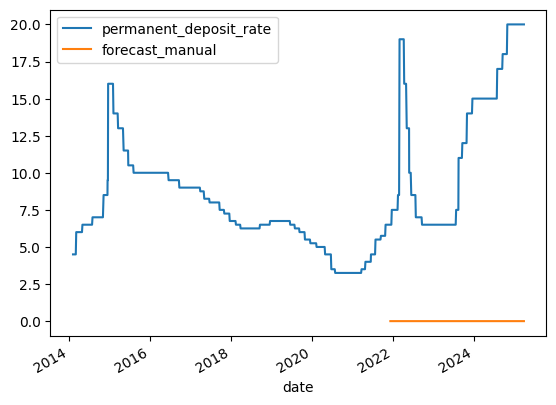

In [ ]:
forecast_test = model_pq_fit.forecast(len(test))
df['forecast_manual'] = [None]*len(train) + list(forecast_test)
df.plot()

In [ ]:
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 12.213559394987396
mape - manual: 0.9999031951224194
rmse - manual: 13.211643685603098


Получить какие-либо адекватные предсказания при помощи использованных версий ARIMA не удалось. Вероятно, это связано с тем, что данные содержат много всплесков, сезонность не выделяется.

Попробуем преобразовать данные так, чтобы сгладить выбросы.


# ARIMA на сглаженных данных

Попробуем построить модель ARIMA на основе ряда, сглаженного при помощи медианы.

In [ ]:
train = df_median.drop(df_median.tail((int(30 * len(df_median) / 100))).index)
test = df_median.tail((int(30 * len(df_median) / 100)))

Проверим ряд на стационарность при помощи теста Дики-Фуллера.

In [ ]:
adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

p-value: 0.09983146714898194


Значение p-value=0.099, значит ряд не является стационарным.

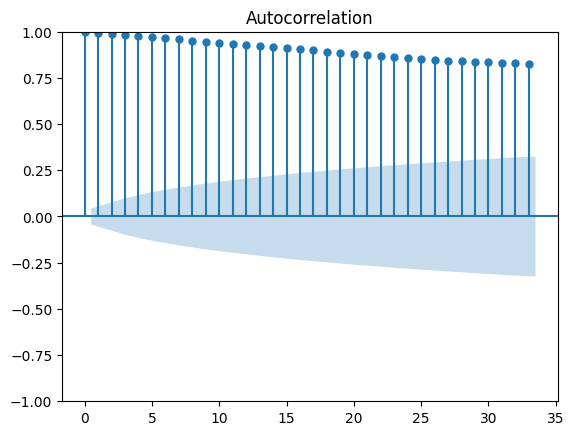

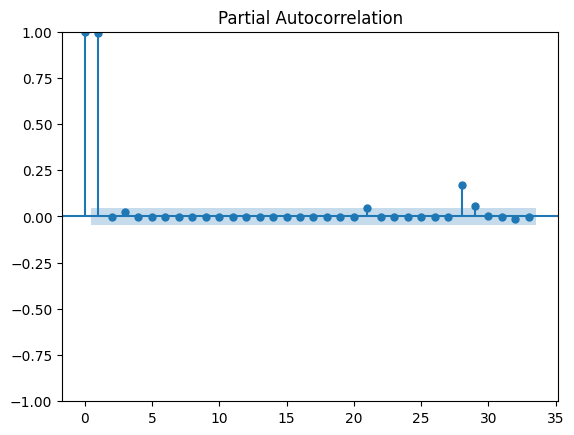

In [ ]:
acf_original = plot_acf(train)
pacf_original = plot_pacf(train)

Выполним дифференцирование и снова проведем тест Дики-Фуллера, чтобы убедится, что ряд стал стационарным.

<Axes: xlabel='date'>

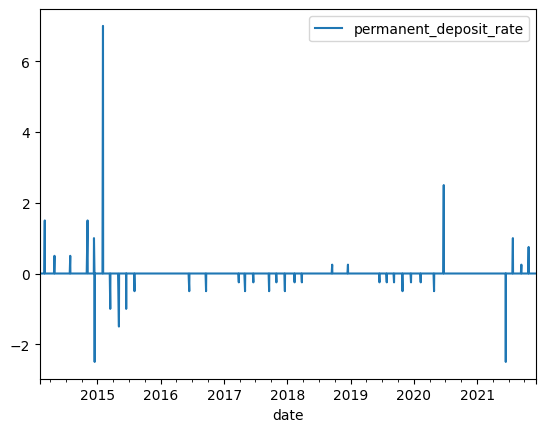

In [ ]:
train_diff = train.diff().dropna()
train_diff.plot()

In [ ]:
adf_test = adfuller(train_diff)
print(f'p-value: {adf_test[1]:.6f}')

p-value: 0.000000


Попробуем при помощи перебора подобрать параметры для модели ARIMA. При помощи перебора значений и вычисления критерия информативности Акаике попробуем понять, какие значения лучше всего подойдут данным. Самое лучшее значение критерия – минимальное.

In [ ]:
p = range(0,10)
d = q = range(0,3)
pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_aic = np.inf
for params in pdq:
  model_test = ARIMA(train, order = params)
  result_test = model_test.fit()
  if result_test.aic < best_aic:
    best_pdq = params
    best_aic = result_test.aic
print(best_pdq, best_aic)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py

(0, 1, 0) -3246.8542667761308


В результате мы получили значение (0, 1, 0). Попробуем обучить модель с такими параметрами.

In [ ]:
model = ARIMA(train, order=(0, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:     permanent_deposit_rate   No. Observations:                 1958
Model:                     ARIMA(0, 1, 0)   Log Likelihood                1624.427
Date:                    Mon, 07 Apr 2025   AIC                          -3246.854
Time:                            15:44:48   BIC                          -3241.275
Sample:                        02-03-2014   HQIC                         -3244.803
                             - 12-07-2021                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0111   1.86e-05    598.105      0.000       0.011       0.011
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          43425724.01
Prob(Q):       

Столбец coef показывает влияние каждого параметра на временной ряд, а P>|z| — значимость. Чем ближе значение P>|z| к нулю, тем выше значимость.

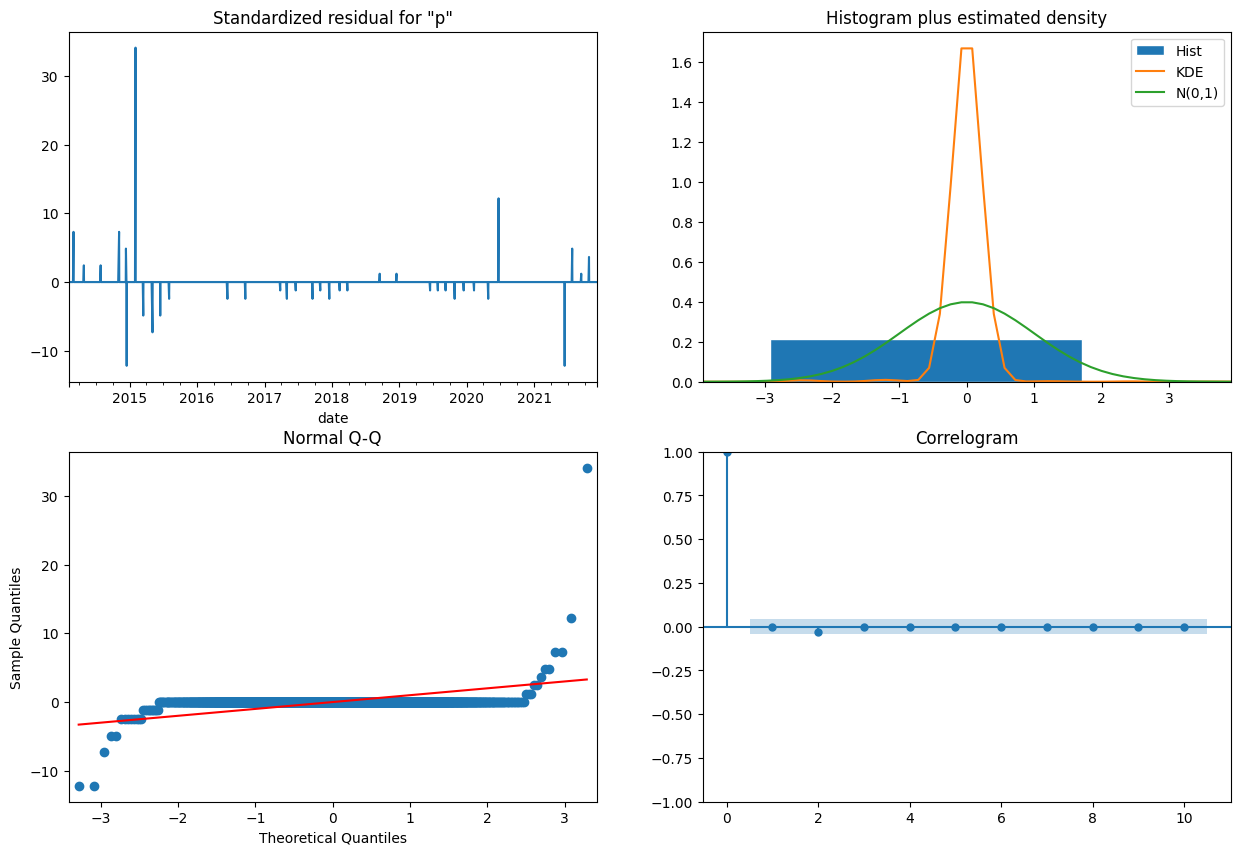

In [ ]:
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

По графику нельзя сказать, что остатки имеют нормальное распределение. Вероятно, модель не походит к данным. Попробуем построить прогноз для 10 тестовых значений.

<Axes: xlabel='date'>

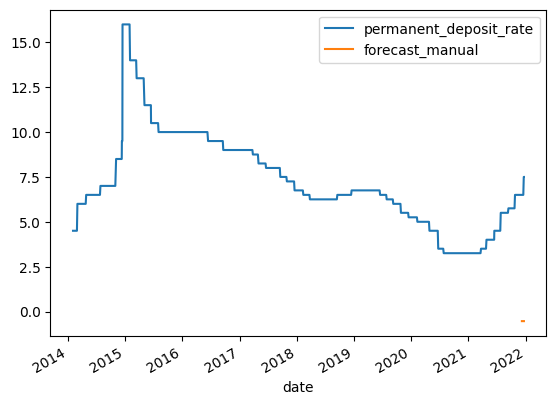

In [ ]:
forecast_test = model_fit.forecast(len(test))[:10]
df = df[:1968]
df['forecast_manual'] = [None]*len(train) + list(forecast_test)
df.plot()

In [ ]:
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.7361244592005989
mape - manual: 0.7014185832121873
rmse - manual: 1.1347976315986341


Таким образом, нам не удалось получить достоверных предсказаний при помощи ARIMA на исследуемом временном ряду. Вероятно, это связано с тем, что в данных присутствует несколько поворотных моментов, а предположения модели не учитывают резких изменений.

# LTSM


LSTM (Long Short-Term Memory) — это усовершенствованный тип архитектуры рекуррентной нейронной сети, предназначенной для работы с последовательными данными путём запоминания информации в течение длительного времени.
LSTM часто эффективны в анализе временных рядов и прогнозировании из-за  способности выявлять долгосрочные закономерности и зависимости в последовательных данных.  


Проведем нормализацию данных при помощи MinMaxScaler – значения будут назодиться в диапазоне от 0 до 1.

In [ ]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = scaled_df.astype('float32')

Разделим данные на тренировочные и тестовые.

In [ ]:
train_size = int(len(scaled_df) * 0.7)
test_size = len(scaled_df) - train_size
train, test = scaled_df[:train_size], scaled_df[train_size:]

In [ ]:
train

array([[0.07462686],
       [0.07462686],
       [0.07462686],
       ...,
       [0.19402985],
       [0.19402985],
       [0.19402985]], dtype=float32)

Создадим функцию, которая будет создавать датасет, применять окна ко временному ряду и преобразует его в тензор. Входной временной ряд представляет собой 2D-массив, а выходные данные функции будут 3D-тензорами. Предполагается прогнозирование на один временной шаг в ближайшее будущее. В дальнейшем можно будет попробовать разные размеры окна и выбрать наилучший.

In [ ]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1956, 1, 1]) torch.Size([1956, 1, 1])
torch.Size([839, 1, 1]) torch.Size([839, 1, 1])


Создадим класс LSTMModel, который будет создавать модель нейронной сети. Сеть будет состоять из слоя LSTM и линейного слоя.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

Обучим сеть на 300 эпохах, выводя значение корня из среднеквадратичной ошибки на каждой 50 эпохе.

In [ ]:
model = LSTMModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.1028, test RMSE 0.2683
Epoch 50: train RMSE 0.0112, test RMSE 0.0276
Epoch 100: train RMSE 0.0113, test RMSE 0.0289
Epoch 150: train RMSE 0.0107, test RMSE 0.0300
Epoch 200: train RMSE 0.0107, test RMSE 0.0306
Epoch 250: train RMSE 0.0107, test RMSE 0.0314


Видим, что на тренировочных данных ошибка падает и не меняется на последних эпохах. На тестовых данных ошибка чуть выше, что нормально, однако она сначала падает, а потом начинает расти. Изобразим предсказания на графике: синим цветом обозначены исходные данные, красным - обучающий набор, зеленым – тестовый набор.

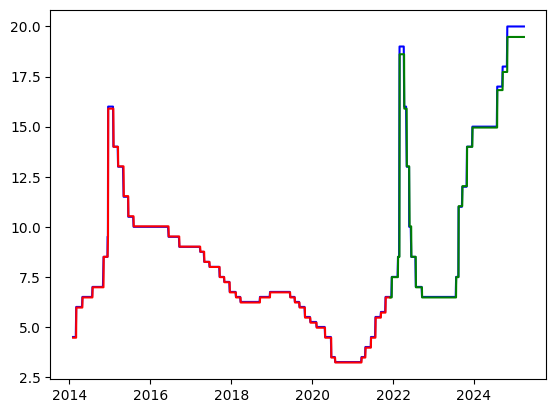

In [ ]:
with torch.no_grad():
    df_pred = df.copy()
    df_pred['train_plot'] = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    y_pred = scaler.inverse_transform(y_pred)
    m = model(X_train)[:, -1, :]
    inverse = scaler.inverse_transform(np.array(m.detach()))
    df_pred['train_plot'].iloc[lookback:train_size] = pd.Series(inverse.tolist())
    df_pred['train_plot'].iloc[lookback:train_size] = [i[0] for i in df_pred['train_plot'].iloc[lookback:train_size]]
    df_pred['test_plot'] = np.ones_like(df) * np.nan
    m_test = model(X_test)[:, -1, :]
    inverse_test = scaler.inverse_transform(np.array(m_test.detach()))
    df_pred['test_plot'].iloc[train_size+lookback:] = pd.Series(inverse_test.tolist())
    df_pred['test_plot'].iloc[train_size+lookback:] = [i[0] for i in df_pred['test_plot'].iloc[train_size+lookback:]]
plt.plot(df_pred['permanent_deposit_rate'], c='b')
plt.plot(df_pred['train_plot'], c='r')
plt.plot(df_pred['test_plot'], c='g')
plt.show()

Видим, что графически предсказания на тренировочной выборке почти идельано повторяют данные. На тестовых данных модель отработала хуже, однако уловила основные тенденции и пики.

Попробуем изменить размер окна на 3.

In [ ]:
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1954, 3, 1]) torch.Size([1954, 3, 1])
torch.Size([837, 3, 1]) torch.Size([837, 3, 1])


In [ ]:
model = LSTMModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0710, test RMSE 0.1908
Epoch 50: train RMSE 0.0148, test RMSE 0.0284
Epoch 100: train RMSE 0.0127, test RMSE 0.0282
Epoch 150: train RMSE 0.0108, test RMSE 0.0278
Epoch 200: train RMSE 0.0107, test RMSE 0.0295
Epoch 250: train RMSE 0.0129, test RMSE 0.0287


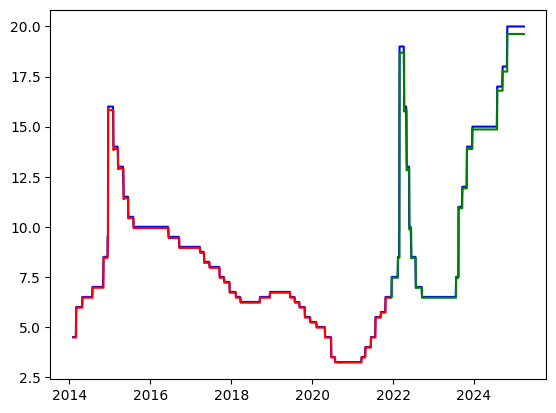

In [ ]:
with torch.no_grad():
    df_pred = df.copy()
    df_pred['train_plot'] = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    y_pred = scaler.inverse_transform(y_pred)
    m = model(X_train)[:, -1, :]
    inverse = scaler.inverse_transform(np.array(m.detach()))
    df_pred['train_plot'].iloc[lookback:train_size] = pd.Series(inverse.tolist())
    df_pred['train_plot'].iloc[lookback:train_size] = [i[0] for i in df_pred['train_plot'].iloc[lookback:train_size]]
    df_pred['test_plot'] = np.ones_like(df) * np.nan
    m_test = model(X_test)[:, -1, :]
    inverse_test = scaler.inverse_transform(np.array(m_test.detach()))
    df_pred['test_plot'].iloc[train_size+lookback:] = pd.Series(inverse_test.tolist())
    df_pred['test_plot'].iloc[train_size+lookback:] = [i[0] for i in df_pred['test_plot'].iloc[train_size+lookback:]]
plt.plot(df_pred['permanent_deposit_rate'], c='b')
plt.plot(df_pred['train_plot'], c='r')
plt.plot(df_pred['test_plot'], c='g')
plt.show()

На тестовой выборке происходит небольшое переобучение, однако графиечски прогнозы модели более близки к реальным.

Попробуем изменить размер окна на 4.

In [ ]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1953, 4, 1]) torch.Size([1953, 4, 1])
torch.Size([836, 4, 1]) torch.Size([836, 4, 1])


In [ ]:
model = LSTMModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 300
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0807, test RMSE 0.2108
Epoch 50: train RMSE 0.0107, test RMSE 0.0290
Epoch 100: train RMSE 0.0133, test RMSE 0.0281
Epoch 150: train RMSE 0.0127, test RMSE 0.0287
Epoch 200: train RMSE 0.0108, test RMSE 0.0298
Epoch 250: train RMSE 0.0108, test RMSE 0.0309


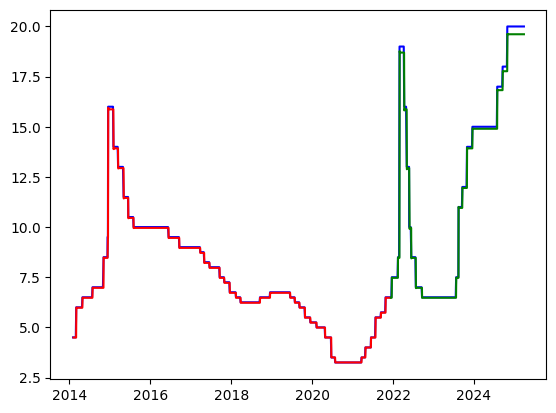

In [ ]:
with torch.no_grad():
    df_pred = df.copy()
    df_pred['train_plot'] = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    y_pred = scaler.inverse_transform(y_pred)
    m = model(X_train)[:, -1, :]
    inverse = scaler.inverse_transform(np.array(m.detach()))
    df_pred['train_plot'].iloc[lookback:train_size] = pd.Series(inverse.tolist())
    df_pred['train_plot'].iloc[lookback:train_size] = [i[0] for i in df_pred['train_plot'].iloc[lookback:train_size]]
    df_pred['test_plot'] = np.ones_like(df) * np.nan
    m_test = model(X_test)[:, -1, :]
    inverse_test = scaler.inverse_transform(np.array(m_test.detach()))
    df_pred['test_plot'].iloc[train_size+lookback:] = pd.Series(inverse_test.tolist())
    df_pred['test_plot'].iloc[train_size+lookback:] = [i[0] for i in df_pred['test_plot'].iloc[train_size+lookback:]]
plt.plot(df_pred['permanent_deposit_rate'], c='b')
plt.plot(df_pred['train_plot'], c='r')
plt.plot(df_pred['test_plot'], c='g')
plt.show()

Присутствует небольшое переобучение на тестовой выборке, однако граафически модель выглядит лучше. Попробуем сохрнить ее и сделать предсказание на ближайшие 30 дней.

In [ ]:
torch.save(model.state_dict(), 'lstm_model.pth')

In [ ]:
model.load_state_dict(torch.load('lstm_model.pth'))
model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

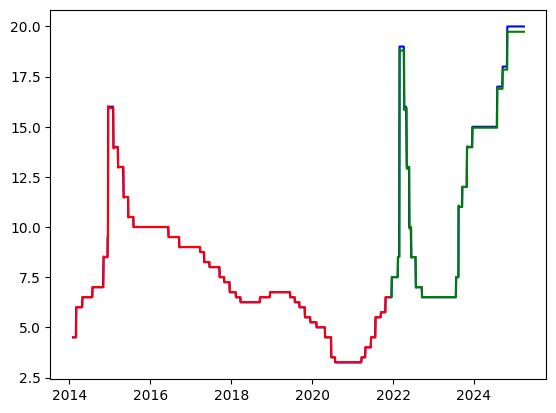

In [ ]:
with torch.no_grad():
    df_pred = df.copy()
    df_pred['train_plot'] = np.ones_like(df) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    y_pred = scaler.inverse_transform(y_pred)
    m = model(X_train)[:, -1, :]
    inverse = scaler.inverse_transform(np.array(m.detach()))
    df_pred['train_plot'].iloc[lookback:train_size] = pd.Series(inverse.tolist())
    df_pred['train_plot'].iloc[lookback:train_size] = [i[0] for i in df_pred['train_plot'].iloc[lookback:train_size]]
    df_pred['test_plot'] = np.ones_like(df) * np.nan
    m_test = model(X_test)[:, -1, :]
    inverse_test = scaler.inverse_transform(np.array(m_test.detach()))
    df_pred['test_plot'].iloc[train_size+lookback:] = pd.Series(inverse_test.tolist())
    df_pred['test_plot'].iloc[train_size+lookback:] = [i[0] for i in df_pred['test_plot'].iloc[train_size+lookback:]]
plt.plot(df_pred['permanent_deposit_rate'], c='b')
plt.plot(df_pred['train_plot'], c='r')
plt.plot(df_pred['test_plot'], c='g')
plt.show()

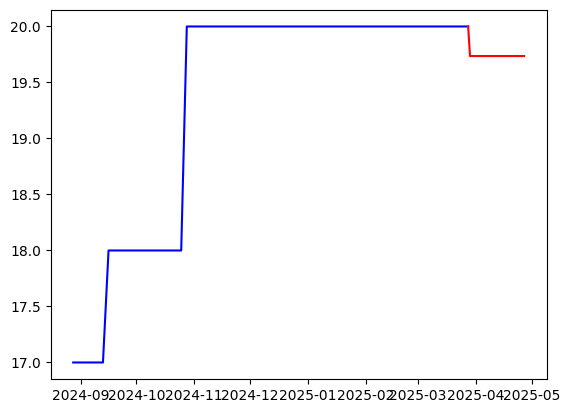

In [ ]:
future_steps = 30
predictions = []
input_seq = X_test[-30:]

with torch.no_grad():
    # Прогнозируем будущие значения шаг за шагом
    for _ in range(future_steps):
        # Получаем прогноз
        pred = model(input_seq)
        pred = pred[:, -1, :]
        predictions.append(pred.squeeze().numpy())
    df_next = df.copy()
    next_dates = pd.date_range(start=df_next.index[-1] + pd.DateOffset(days=1), periods=30)
    df_next['next_plot'] = np.ones_like(df) * np.nan
    df_next = df_next.reindex(df_next.index.to_list() + next_dates.tolist())
    df_next['next_plot'].iloc[-30:] = pd.Series(scaler.inverse_transform(predictions[0].reshape(-1, 1)).flatten())
    df_next['next_plot'].iloc[-31] = df_next['permanent_deposit_rate'].iloc[-31]

plt.plot(df_next['permanent_deposit_rate'].iloc[-180:-30], c='b')
plt.plot(df_next['next_plot'], c='r')
plt.show()

Видим, что предсказания близки к значениям последних данных.

In [ ]:
df_next.to_csv('next_preds.csv')



# Вывод

В ходе работы был проанализирован временный ряд процентных ставок по депозитам овернайт, который содержит ежедневные значения процентной ставки с 3 февраля 2014 года по 28 марта 2025 года.

Перед началом работы с временным рядом посредством Selenium были получены значения процентных ставок с сайта Центрального Банка РФ. Далее был сформирован датафрейм с датами и процентными ставками. Работа далее велась с датафреймом.

Первичный анализ данных выявил наличие пропусков, которые далее были удалены. При анализе мы попытались разделить ряд на компоненты - тренд, сезонность и шум – при помощи классической декомпозиции, STL- декомпозиции. Также мы построили скользящие средние. Выявить цикличность данных не удалось.

Были выдвинуты следующие гипотезы:

1.	На проверку стационарности:

  a.	H0 - ряд нестационарен.

  b.	H1 - ряд стационарен.

2.	На проверку наличия тренда:

  a.	H0 - ряд является стационарным, то есть не имеет единичного корня (единичный корень подразумевает стохастический тренд или стационарность).

  b.	H1 - ряд не является стационарным из-за единичного корня.

Проверка ряда на стационарность проводилась при помощи теста Дики — Фуллера. Значение p-value = 0.763225 при значении статистики -0.972320; значение p-value > 0.05, это значит, что мы не можем отвергнуть нулевую гипотезу, исследуемый ряд является нестационарным.

Проверка ряда на наличие тренда проводилась при помощи теста Квятковского-Филлипса-Шмидта-Шина. Значение статистики stat=1.732, p-value = 0.010; значение p-value < 0.05, это значит, что мы не можем принять нулевую гипотезу о том, что ряд является стационарным. Это значит, что ряд не подразумевает тренд и стационарность.

Для прогноза значений сначала использовалась модель ARIMA. Были построены несколько вариантов моделей, но адекватных предсказаний с их помощью получить не удалось. Был осуществлен подбор параметров, но это не привело к нужным результатам. Можно связать это с тем, что ARIMA не устойчива к резким изменениям в данных и чувствительна к выбросам.

Далее для прогноза значений использовалась нейронная архитектура, состоящая LSTM и линейного слоя. Модель показала лучший результат. Модель для обучения применяла окно ко временному ряду. Модель обучалась на 300 эпохах. Наилучший результат получился с размером окна 4. При помощи модели были созданы прогнозы процентной ставки на 30 дней вперед. В дальнейшем можно обновлять данные и предсказывать процентную ставку. Модель LSTM рекомендуется для дальнейшего использования.

Исходя из проведенного исследования можно сделать вывод, что анализ временных рядов является сложной и полезной задачей. Временные ряды помогают выявить закономерности и прогнозировать будущее в разных сферах. Анализ временных рядов позволяет определить влияние различных факторов на изменение ряда. Методы анализа временных рядов имеют свои недостатки: случайные факторы и внеплановые значения могут привести к неверному прогнозу.
